# 빅쿼리 연결

In [ ]:
from google.colab import auth
auth.authenticate_user()

# BigQuery
from google.cloud import bigquery

# viz libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.express as px

# viz settings
%matplotlib inline
sns.set()
init_notebook_mode(connected=True)

import plotly.io as pio
pio.renderers.default = "colab"

!pip install koreanize-matplotlib
import koreanize_matplotlib

%config InlineBackend.figure_format = 'retina'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 48.6 MB/s eta 0:00:00


In [ ]:
# Client 객체 생성
client = bigquery.Client(project = '755804531278')

# 데이터셋 참조경로(reference) 설정
# Kaggle커널에서는 bq_helper를 대신 사용할 수도 있다.
dataset_ref = client.dataset('google_analytics_sample', project='bigquery-public-data')

# 해당 경로로부터 데이터셋 추출
dataset = client.get_dataset(dataset_ref)

# 데이터셋을 테이블 단위로 보기
tables = list(client.list_tables(dataset))
table_names = sorted([t.table_id for t in tables])

# 테이블 단위로 간단한 정보 확인
print(f"""table 개수 : {len(tables)}
tables : {", ".join(table_names[:3])}, ...
date 범위 : {table_names[0][-8:]} ~ {table_names[-1][-8:]}""")

# 테이블 경로 생성
table_ref_temp = dataset_ref.table(table_names[0])

# 테이블 가져오기
table_temp = client.get_table(table_ref_temp)

# 컬럼 확인
client.list_rows(table_temp, max_results=5).to_dataframe()

table 개수 : 369
tables : Google-ecommerce-dataset-table, daily_total_visits, daily_visits, ...
date 범위 : et-table ~ 20170801


""


# 1.A(Acquisition)

## 1-1. source별 유입 세션 수

- trafficSource.source별  
세션 수(fullVisitorId + visitId 조합 고유 수)와 새로운 방문자 수(totals.newVisits = 1) 집계

In [ ]:
# source
query = f"""
SELECT
  trafficSource.source AS source,
  COUNT(DISTINCT CONCAT(CAST(fullVisitorId AS STRING), CAST(visitId AS STRING))) AS sessions,
  SUM(CASE WHEN totals.newVisits = 1 THEN 1 ELSE 0 END) AS new_users,
  COUNT(CASE WHEN totals.newVisits IS NULL THEN 1 END) AS revisit_users
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
  _TABLE_SUFFIX BETWEEN '20160801' AND '20170731'
GROUP BY
  source
ORDER BY
  sessions DESC
LIMIT 10

"""

source_stats = client.query(query).result().to_dataframe()
source_stats

,source,sessions,new_users,revisit_users
0,(direct),368935,260414,108889
1,google,241021,188395,52885
2,youtube.com,212341,199749,12673
3,Partners,16328,12472,3887
4,analytics.google.com,16074,9219,6896
5,dfa,5668,1530,4141
6,google.com,4647,4098,559
7,m.facebook.com,3355,3032,328
8,baidu,3346,3113,238
9,sites.google.com,2975,1056,1919


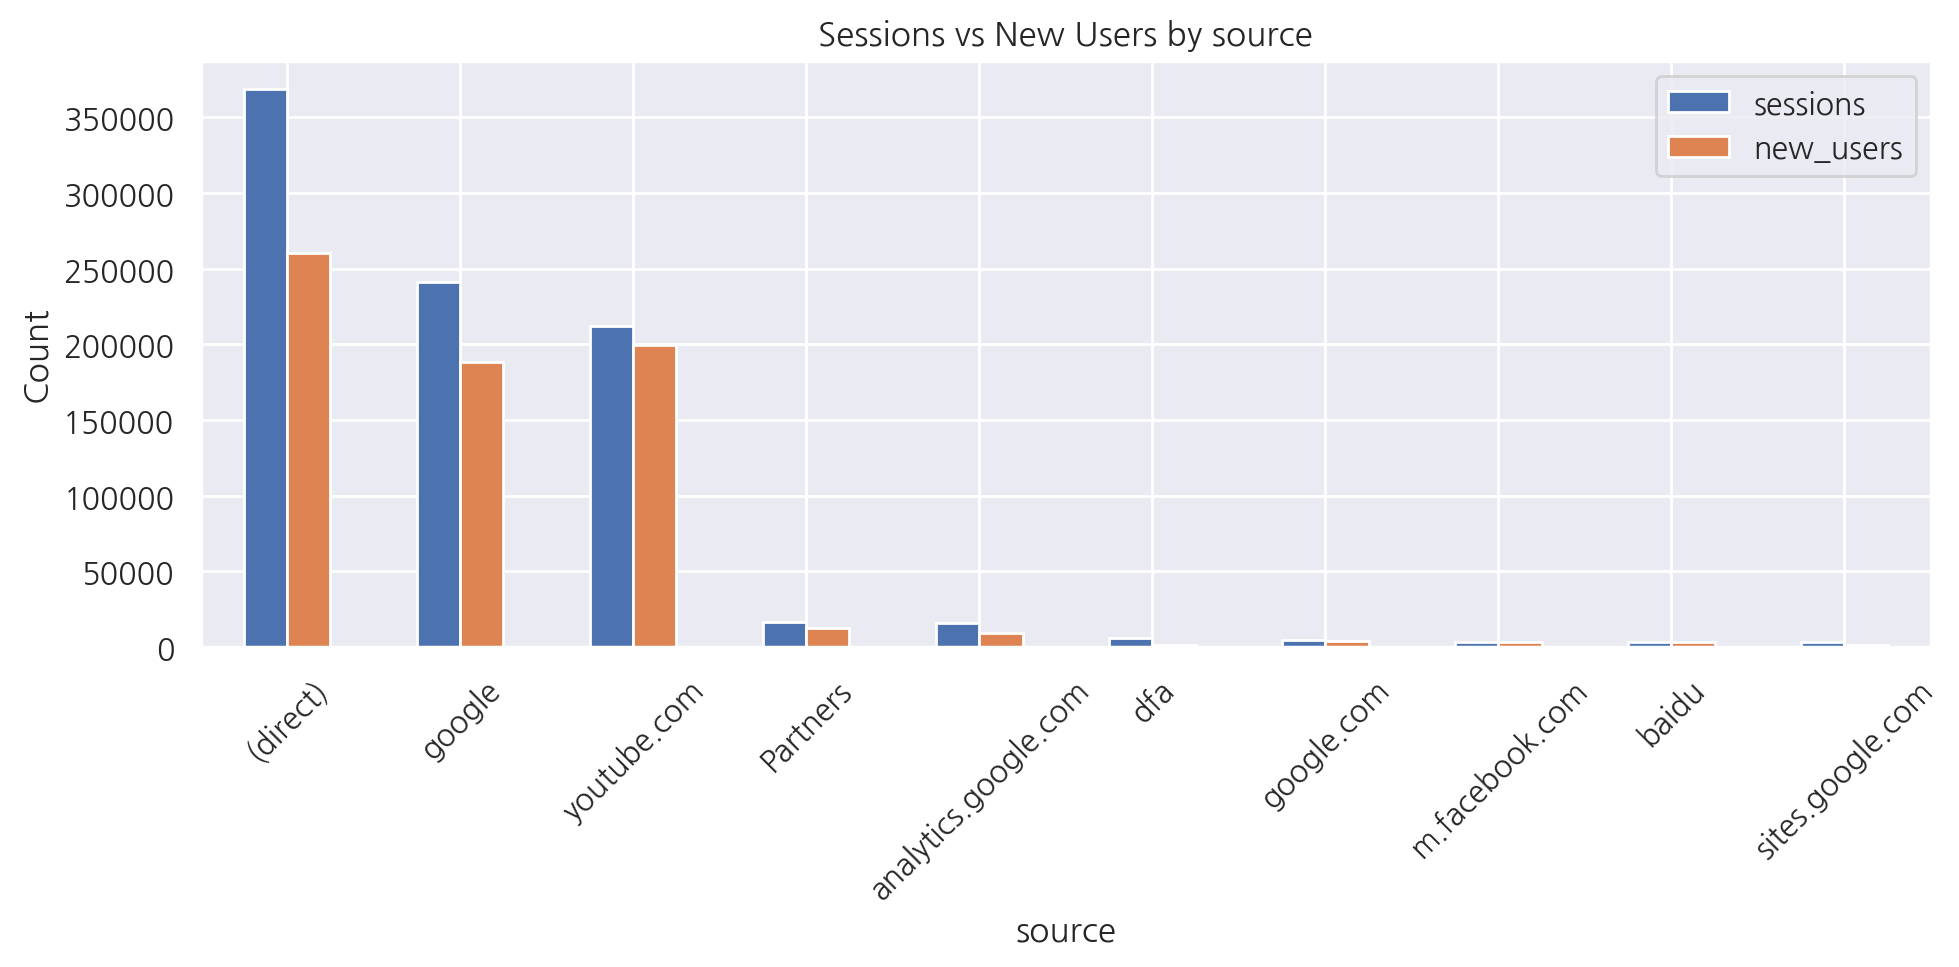

In [ ]:
# Bar Chart(세션 수 & 신규 사용자 수)
def plot_acquisition(stats, column_name):
    ax = stats.plot(
        x=column_name,
        y=['sessions', 'new_users'],
        kind='bar',
        figsize=(10, 5),
        title=f"Sessions vs New Users by {column_name}",
        xlabel=column_name,
        ylabel="Count",
        legend=True
    )
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_acquisition(source_stats, 'source')

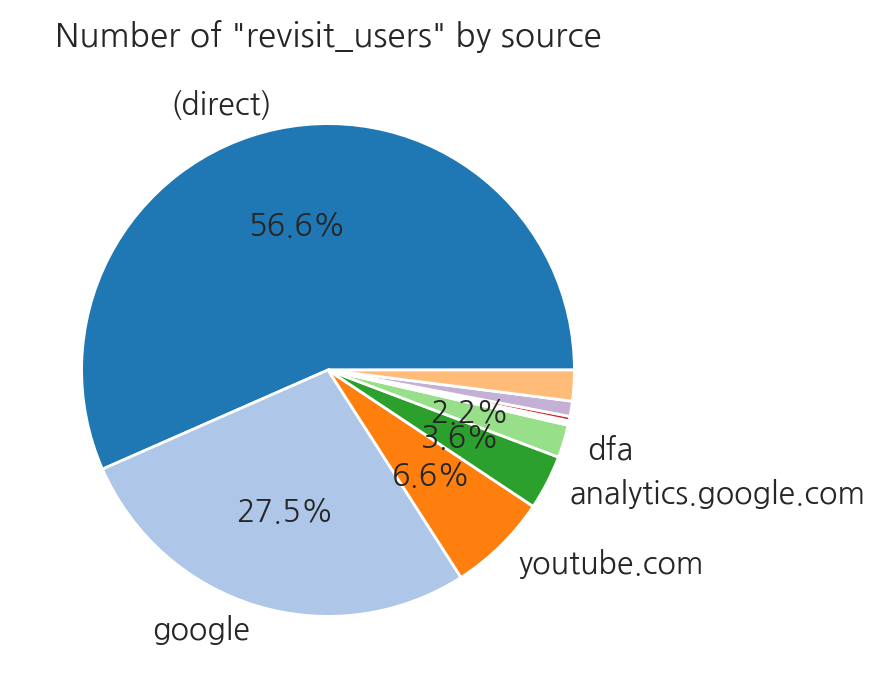

In [ ]:
# Pie Chart (재방문자)

#상위 5개 범주
top_sources = source_stats.nlargest(5, 'revisit_users')
other_sources = source_stats.nsmallest(len(source_stats) - 5, 'revisit_users')

labels = list(top_sources['source']) + list(other_sources['source'])
sizes = list(top_sources['revisit_users']) + list(other_sources['revisit_users'])

# 색상
base_colors = list(plt.cm.tab20.colors)
all_sources = source_stats['source'].unique()
color_map = {src: base_colors[i % len(base_colors)] for i, src in enumerate(all_sources)}

# 파이차트에 색상 적용
colors = [color_map[l] for l in labels]

#파이차트 그리기
plt.figure(figsize=(4,4))
wedges, texts, autotexts = plt.pie(
    sizes,
    labels=[label if i < n else '' for i, label in enumerate(labels)],
    autopct='',
    colors=colors,
    textprops={'fontsize':11}
)

#일부만 퍼센트 표시
total = sum(sizes)
for i, autotext in enumerate(autotexts):
    if i < 5:
        pct = sizes[i] / total * 100
        autotext.set_text(f'{pct:.1f}%')
    else:
        autotext.set_text('')

plt.title('Number of "revisit_users" by source')
plt.show()


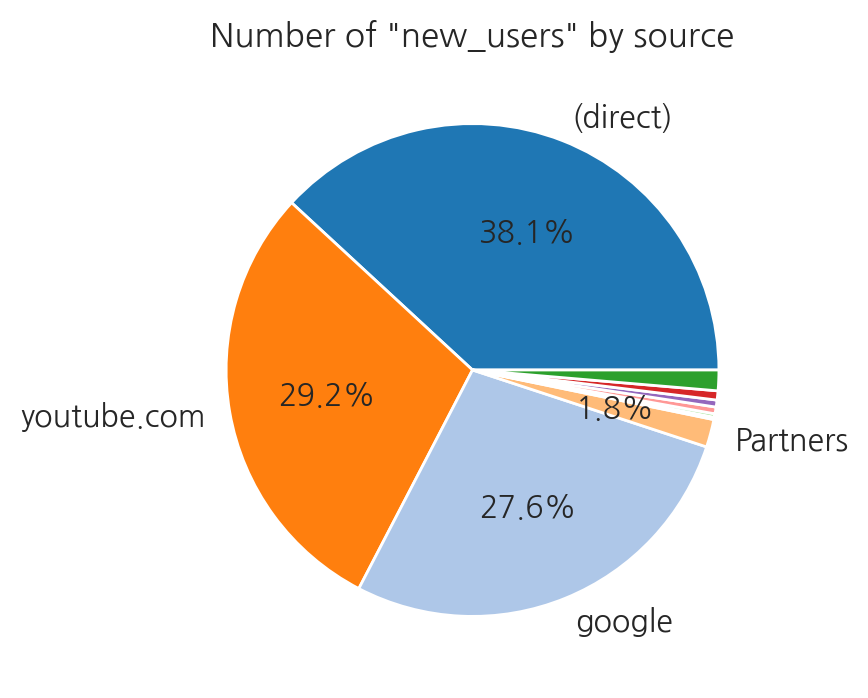

In [ ]:
# Pie Chart (신규 사용자 수)

# 상위 4개 범주
top_sources = source_stats.nlargest(4, 'new_users')
other_sources = source_stats.nsmallest(len(source_stats) - 4, 'new_users')

labels = list(top_sources['source']) + list(other_sources['source'])
sizes = list(top_sources['new_users']) + list(other_sources['new_users'])

# 색상
base_colors = list(plt.cm.tab20.colors)

# 이전 파이차트의 색상 동일하게 적용
colors = [color_map[l] for l in labels]

# 파이차트 그리기
plt.figure(figsize=(4,4))
wedges, texts, autotexts = plt.pie(
    sizes,
    labels=[label if i < 4 else '' for i, label in enumerate(labels)],
    autopct='',
    colors=colors,
    textprops={'fontsize':11}
)

# 일부만 퍼센트 표시
total = sum(sizes)
for i, autotext in enumerate(autotexts):
    if i < 4:
        pct = sizes[i] / total * 100
        autotext.set_text(f'{pct:.1f}%')
    else:
        autotext.set_text('')

plt.title('Number of "new_users" by source')
plt.show()


## 1-2. source+medium별 유입 세션 수

- trafficSource.source & trafficSource.medium별  
세션 수(fullVisitorId + visitId 조합 고유 수)와 새로운 방문자 수(totals.newVisits = 1) 집계

In [ ]:
# source + medium
query = f"""
SELECT
  trafficSource.source AS source,
  trafficSource.medium AS medium,
  COUNT(DISTINCT CONCAT(CAST(fullVisitorId AS STRING), CAST(visitId AS STRING))) AS sessions,
  SUM(CASE WHEN totals.newVisits = 1 THEN 1 ELSE 0 END) AS new_users,
  COUNT(CASE WHEN totals.newVisits IS NULL THEN 1 END) AS revisit_users
FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170731'
GROUP BY
  source, medium
ORDER BY
  sessions DESC
LIMIT 10
"""

source_medium_stats = client.query(query).result().to_dataframe()
source_medium_stats['source_medium'] = source_medium_stats['source'] + '_' + source_medium_stats['medium']
source_medium_stats=source_medium_stats[['source_medium','sessions','new_users','revisit_users']]
source_medium_stats


,source_medium,sessions,new_users,revisit_users
0,(direct)_(none),368933,260412,108889
1,google_organic,227427,180072,47596
2,youtube.com_referral,212341,199749,12673
3,Partners_affiliate,16320,12466,3885
4,analytics.google.com_referral,16074,9219,6896
5,google_cpc,13060,8014,5064
6,dfa_cpm,5668,1530,4141
7,google.com_referral,4647,4098,559
8,m.facebook.com_referral,3355,3032,328
9,baidu_organic,3346,3113,238


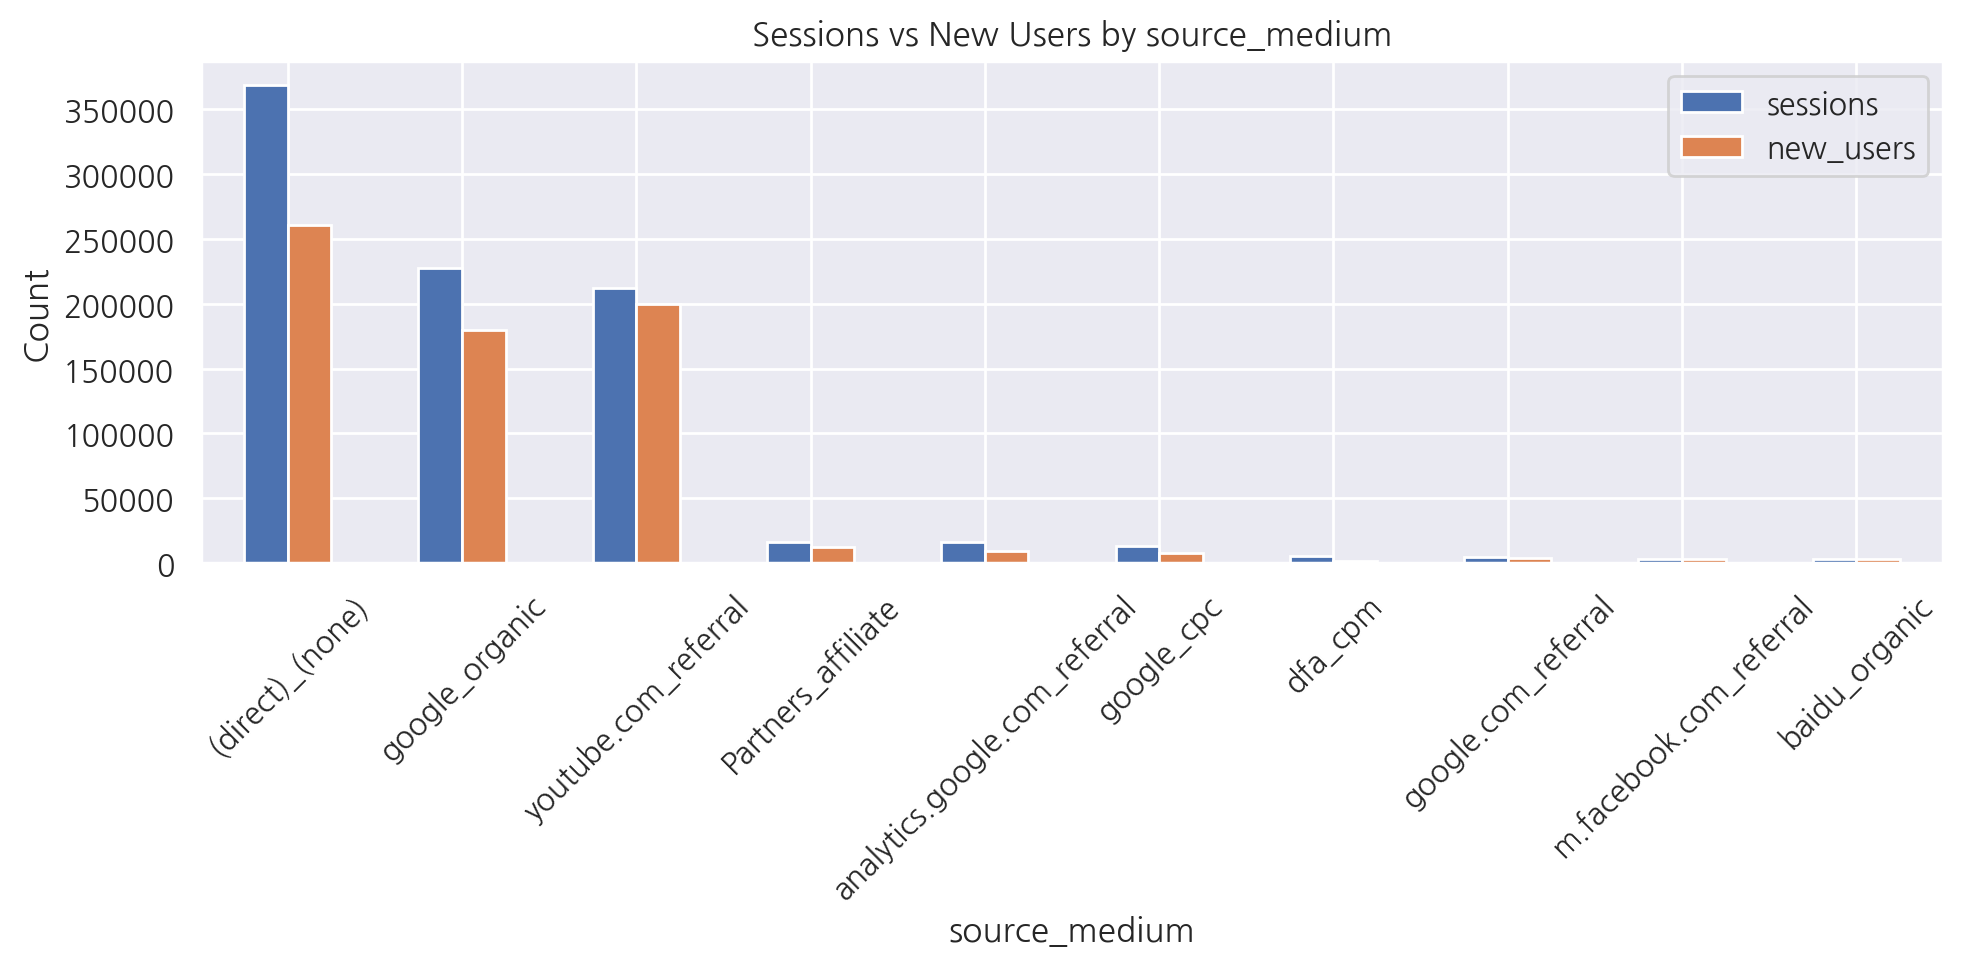

In [ ]:
# bar chart
plot_acquisition(source_medium_stats, 'source_medium')

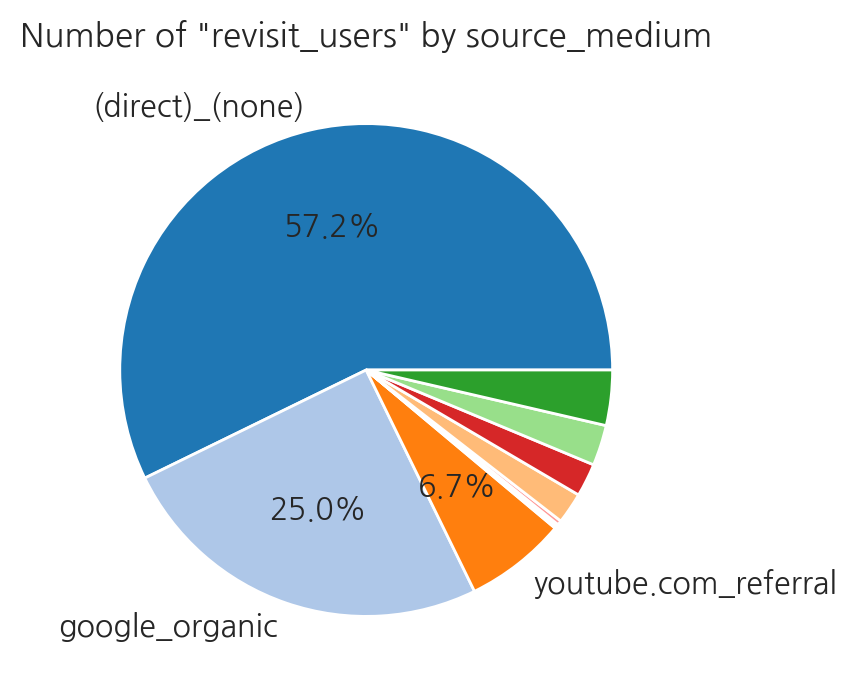

In [ ]:
# Pie Chart (재방문자 수)

#상위 3개의 범주
n = 3
top_sources = source_medium_stats.nlargest(n, 'revisit_users')
other_sources = source_medium_stats.nsmallest(len(source_medium_stats) - n, 'revisit_users')

labels = list(top_sources['source_medium']) + list(other_sources['source_medium'])
sizes = list(top_sources['revisit_users']) + list(other_sources['revisit_users'])

# 색상
base_colors = list(plt.cm.tab20.colors)
all_sources = source_medium_stats['source_medium'].unique()
color_map = {src: base_colors[i % len(base_colors)] for i, src in enumerate(all_sources)}

# 파이차트에 색상 적용
colors = [color_map[l] for l in labels]

#파이차트 그리기
plt.figure(figsize=(4,4))
wedges, texts, autotexts = plt.pie(
    sizes,
    labels=[label if i < n else '' for i, label in enumerate(labels)],
    autopct='',
    colors=colors,
    textprops={'fontsize':11}
)

# 일부만 퍼센트 표시
total = sum(sizes)
for i, autotext in enumerate(autotexts):
    if i < n:
        pct = sizes[i] / total * 100
        autotext.set_text(f'{pct:.1f}%')
    else:
        autotext.set_text('')

plt.title('Number of "revisit_users" by source_medium')
plt.show()


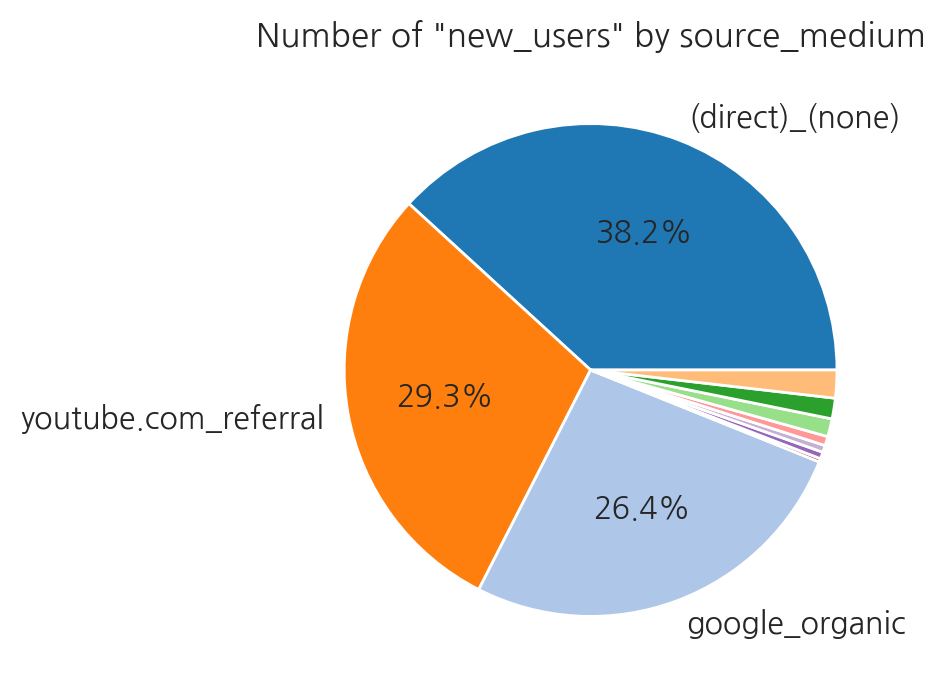

In [ ]:
# Pie Chart (신규 사용자 수)
import matplotlib.pyplot as plt
n = 3
top_sources = source_medium_stats.nlargest(n, 'new_users')
other_sources = source_medium_stats.nsmallest(len(source_medium_stats) - n, 'new_users')

labels = list(top_sources['source_medium']) + list(other_sources['source_medium'])
sizes = list(top_sources['new_users']) + list(other_sources['new_users'])

# 색상
base_colors = list(plt.cm.tab20.colors)

# 이전 파이차트의 색상 동일하게 적용
colors = [color_map[l] for l in labels]

# 파이차트 그리기
plt.figure(figsize=(4,4))
wedges, texts, autotexts = plt.pie(
    sizes,
    labels=[label if i < n else '' for i, label in enumerate(labels)],
    autopct='',
    colors=colors,
    textprops={'fontsize':11}
)

# 일부만 퍼센트 표시
total = sum(sizes)
for i, autotext in enumerate(autotexts):
    if i < n:
        pct = sizes[i] / total * 100
        autotext.set_text(f'{pct:.1f}%')
    else:
        autotext.set_text('')

plt.title('Number of "new_users" by source_medium')
plt.show()


## 1-3.  channelGrouping별 유입 세션 수

- channelGrouping별  
세션 수(fullVisitorId + visitId 조합 고유 수)와 새로운 방문자 수(totals.newVisits = 1) 집계

In [ ]:
# --- 쿼리: channelGrouping x source x medium + 고유 사용자수 ---
query = f"""
SELECT
  channelGrouping,
  trafficSource.source AS source,
  trafficSource.medium AS medium,
  COUNT(DISTINCT fullVisitorId) AS users
FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
    _table_suffix between '20160801' and '20170801'
GROUP BY channelGrouping, source, medium
HAVING users > 0
"""

df = client.query(query).result().to_dataframe()

# 라벨 정리
df['source'] = df['source'].fillna('(not set)')
df['medium'] = df['medium'].fillna('(not set)')

# --- Sunburst ---
import plotly.express as px

fig = px.sunburst(
    df,
    path=['channelGrouping', 'source', 'medium'],
    values='users',
    title=f'Channel → Source → Medium 사용자 구성'
)
fig.update_layout(margin=dict(t=60, l=0, r=0, b=0))
fig.show()

In [ ]:
# channelGrouping
query = f"""
SELECT
  channelGrouping,
  COUNT(DISTINCT CONCAT(CAST(fullVisitorId AS STRING), CAST(visitId AS STRING))) AS sessions,
  SUM(CASE WHEN totals.newVisits = 1 THEN 1 ELSE 0 END) AS new_users,
  COUNT(CASE WHEN totals.newVisits IS NULL THEN 1 END) AS revisit_users
FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170731'
GROUP BY
  channelGrouping
ORDER BY
  sessions DESC
LIMIT 10
"""

channelGrouping_stats = client.query(query).result().to_dataframe()
channelGrouping_stats


,channelGrouping,sessions,new_users,revisit_users
0,Organic Search,379792,301536,78679
1,Social,225807,209858,16046
2,Direct,142456,106542,36084
3,Referral,104265,53175,51227
4,Paid Search,25220,15722,9534
5,Affiliates,16320,12466,3885
6,Display,6220,1864,4359
7,(Other),120,25,95


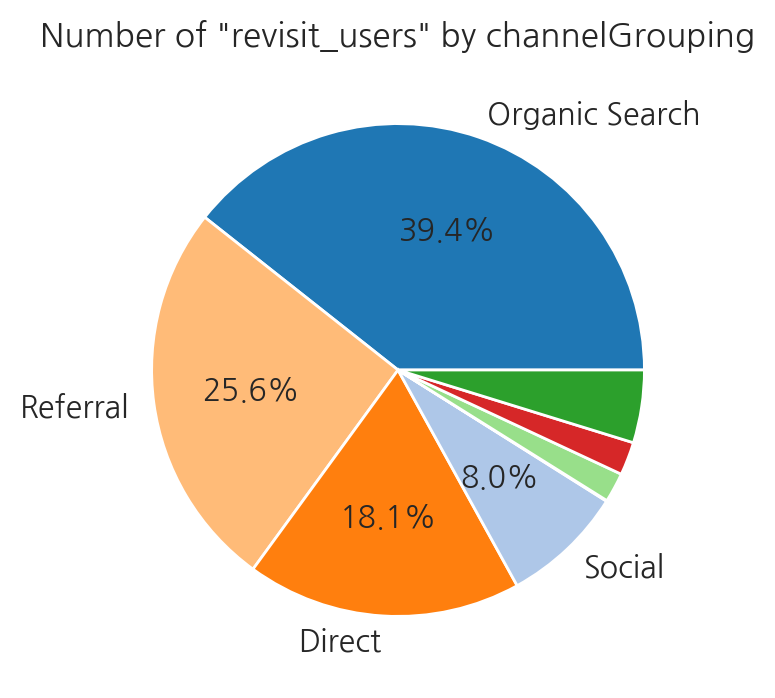

In [ ]:
# Bar Chart (재방문자 수)
n = 4
top_sources = channelGrouping_stats.nlargest(n, 'revisit_users')
other_sources = channelGrouping_stats.nsmallest(len(channelGrouping_stats) - n, 'revisit_users')

labels = list(top_sources['channelGrouping']) + list(other_sources['channelGrouping'])
sizes = list(top_sources['revisit_users']) + list(other_sources['revisit_users'])

# 색상
base_colors = list(plt.cm.tab20.colors)
all_sources = channelGrouping_stats['channelGrouping'].unique()
color_map = {src: base_colors[i % len(base_colors)] for i, src in enumerate(all_sources)}

# 파이차트에 색상 적용
colors = [color_map[l] for l in labels]

#파이차트 그리기
plt.figure(figsize=(4,4))
wedges, texts, autotexts = plt.pie(
    sizes,
    labels=[label if i < n else '' for i, label in enumerate(labels)],
    autopct='',
    colors=colors,
    textprops={'fontsize':11}
)

# 일부만 퍼센트 표시
total = sum(sizes)
for i, autotext in enumerate(autotexts):
    if i < n:
        pct = sizes[i] / total * 100
        autotext.set_text(f'{pct:.1f}%')
    else:
        autotext.set_text('')

plt.title('Number of "revisit_users" by channelGrouping')
plt.show()


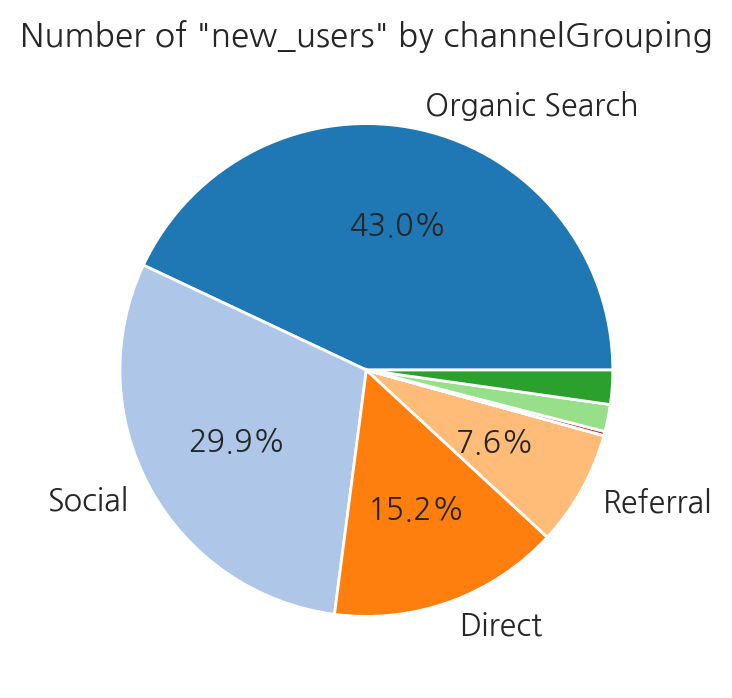

In [ ]:
# Bar Chart (신규 사용자 수)
import matplotlib.pyplot as plt
n = 4
top_sources = channelGrouping_stats.nlargest(n, 'new_users')
other_sources = channelGrouping_stats.nsmallest(len(channelGrouping_stats) - n, 'new_users')

labels = list(top_sources['channelGrouping']) + list(other_sources['channelGrouping'])
sizes = list(top_sources['new_users']) + list(other_sources['new_users'])

# 색상
base_colors = list(plt.cm.tab20.colors)

# 이전 파이차트의 색상 동일하게 적용
colors = [color_map[l] for l in labels]

# 파이차트 그리기
plt.figure(figsize=(4,4))
wedges, texts, autotexts = plt.pie(
    sizes,
    labels=[label if i < n else '' for i, label in enumerate(labels)],
    autopct='',
    colors=colors,
    textprops={'fontsize':11}
)

# 일부만 퍼센트 표시
total = sum(sizes)
for i, autotext in enumerate(autotexts):
    if i < n:
        pct = sizes[i] / total * 100
        autotext.set_text(f'{pct:.1f}%')
    else:
        autotext.set_text('')

plt.title('Number of "new_users" by channelGrouping')
plt.show()


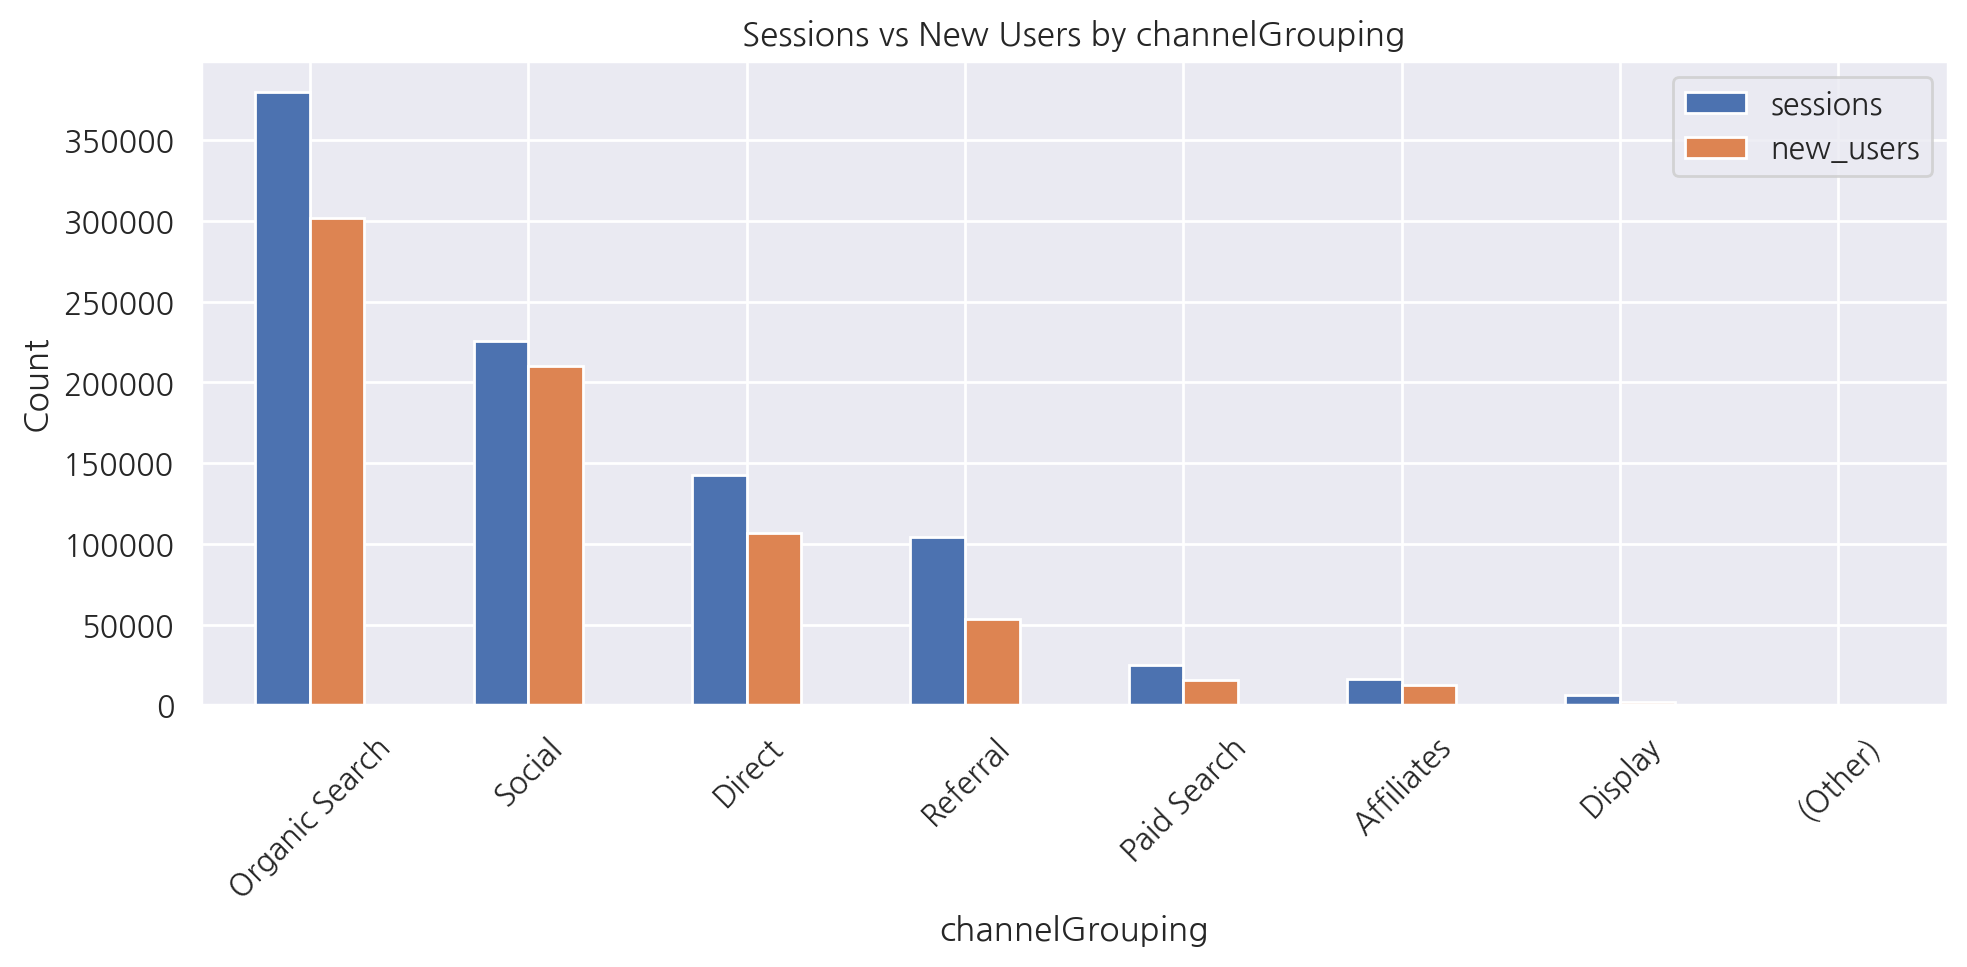

In [ ]:
# bar chart
plot_acquisition(channelGrouping_stats, 'channelGrouping')

## 1-4. medium의 Organic(자연유입) vs Paid(광고유입) 사용자 수 비교

- medium을 투자 비용 유무에 따라 Non_Paid, Paid, Other 3개의 그룹으로 재분류하여 그룹별 세션 수 비교


In [ ]:
# medium의 Organic vs Paid 사용자 수 비교
query = f"""
SELECT
    CASE
      when trafficSource.medium in ('cpc', 'cpm', 'affiliate') then 'Paid'
      when trafficSource.medium in ('organic', 'referral', '(none)') then 'Non_Paid'
      else 'Other'
    END as is_paid,
    COUNT(DISTINCT CONCAT(CAST(fullVisitorId AS STRING), CAST(visitId AS STRING))) AS sessions
FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
    _table_suffix between '20160801' and '20170731'
GROUP BY 1
ORDER BY 2 desc
"""
ad_type_result = client.query(query).result().to_dataframe()
ad_type_result

,is_paid,sessions
0,Non_Paid,864539
1,Paid,35547
2,Other,117


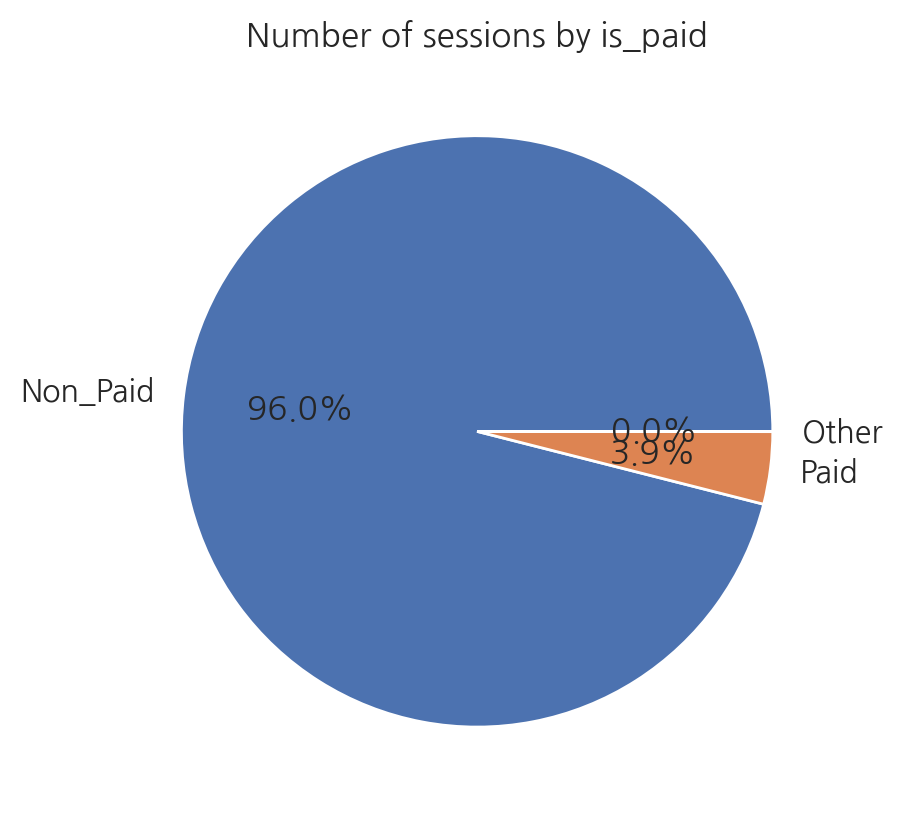

In [ ]:
# Pie Chart
df = ad_type_result.set_index('is_paid')
ax = df.plot.pie(y='sessions', autopct='%1.1f%%', legend=False)
ax.set_ylabel('')
plt.title('Number of sessions by is_paid')
plt.show()

# 2. A(Activation)

## 2-1. channelGrouping별 체류시간 (장기 세션 비율)

- 전체 세션의 체류시간 상위 25%를 기준으로 channelGrouping별 장기 세션 비율 비교
- session_times CTE
  - 세션 범위 정의 (세션별 시작&종료시간 계산)
- session_duration CTE
  - 세션 체류 시간 계산 (종료시작 - 시작시간)
- q3_time CTE
  - 장기세션 기준(Q3) 도출 (전체 세션 분포에서 3사분위수)
- TF_time CTE
  - 장기세션 여부 판단 (각 세션을 Q3와 비교)
- 최종 SELECT
  - 채널별 장기세션 비율 집계

In [ ]:
# channelGrouping별 체류시간(장기 세션 비율)
query="""
WITH session_times AS (
  -- 세션별 시작/종료시간 계산
  SELECT
    channelGrouping,
    fullVisitorId,
    visitId,
    MIN(TIMESTAMP_MILLIS(visitStartTime * 1000 + hits.time)) AS session_start,
    MAX(TIMESTAMP_MILLIS(visitStartTime * 1000 + hits.time)) AS session_end
  FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
       UNNEST(hits) AS hits
  WHERE _TABLE_SUFFIX BETWEEN '20160801' AND '20170731'
  GROUP BY channelGrouping, fullVisitorId, visitId
),

session_duration AS (
  -- 세션별 체류 시간 계산
  SELECT
    channelGrouping,
    TIMESTAMP_DIFF(session_end, session_start, SECOND) AS duration_sec
  FROM session_times
),

q3_time AS (
  -- 전체 세션의 3사분위수(Q3) 계산
  SELECT
    APPROX_QUANTILES(duration_sec, 4)[OFFSET(3)] AS q3
  FROM session_duration
),

TF_time AS (
  -- 장기 세션 여부 판단 (세션 시간 >= Q3)
  SELECT
    s.channelGrouping,
    s.duration_sec,
    q.q3,
    CASE WHEN s.duration_sec >= q.q3 THEN 1 ELSE 0 END AS is_long
  FROM session_duration s
  CROSS JOIN q3_time q
)

SELECT
  channelGrouping AS channel,
  COUNT(*) AS total_sessions,
  SUM(is_long) AS long_sessions,
  ROUND(SAFE_DIVIDE(SUM(is_long), COUNT(*)) * 100, 1) AS long_stay_percent
FROM TF_time
GROUP BY channelGrouping
ORDER BY total_sessions DESC

"""

long_time= client.query(query).result().to_dataframe()
long_time

,channel,total_sessions,long_sessions,long_stay_percent
0,Organic Search,379792,103040,27.1
1,Social,225807,22091,9.8
2,Direct,142456,38492,27.0
3,Referral,104265,43443,41.7
4,Paid Search,25220,8721,34.6
5,Affiliates,16320,4315,26.4
6,Display,6220,2147,34.5
7,(Other),120,37,30.8


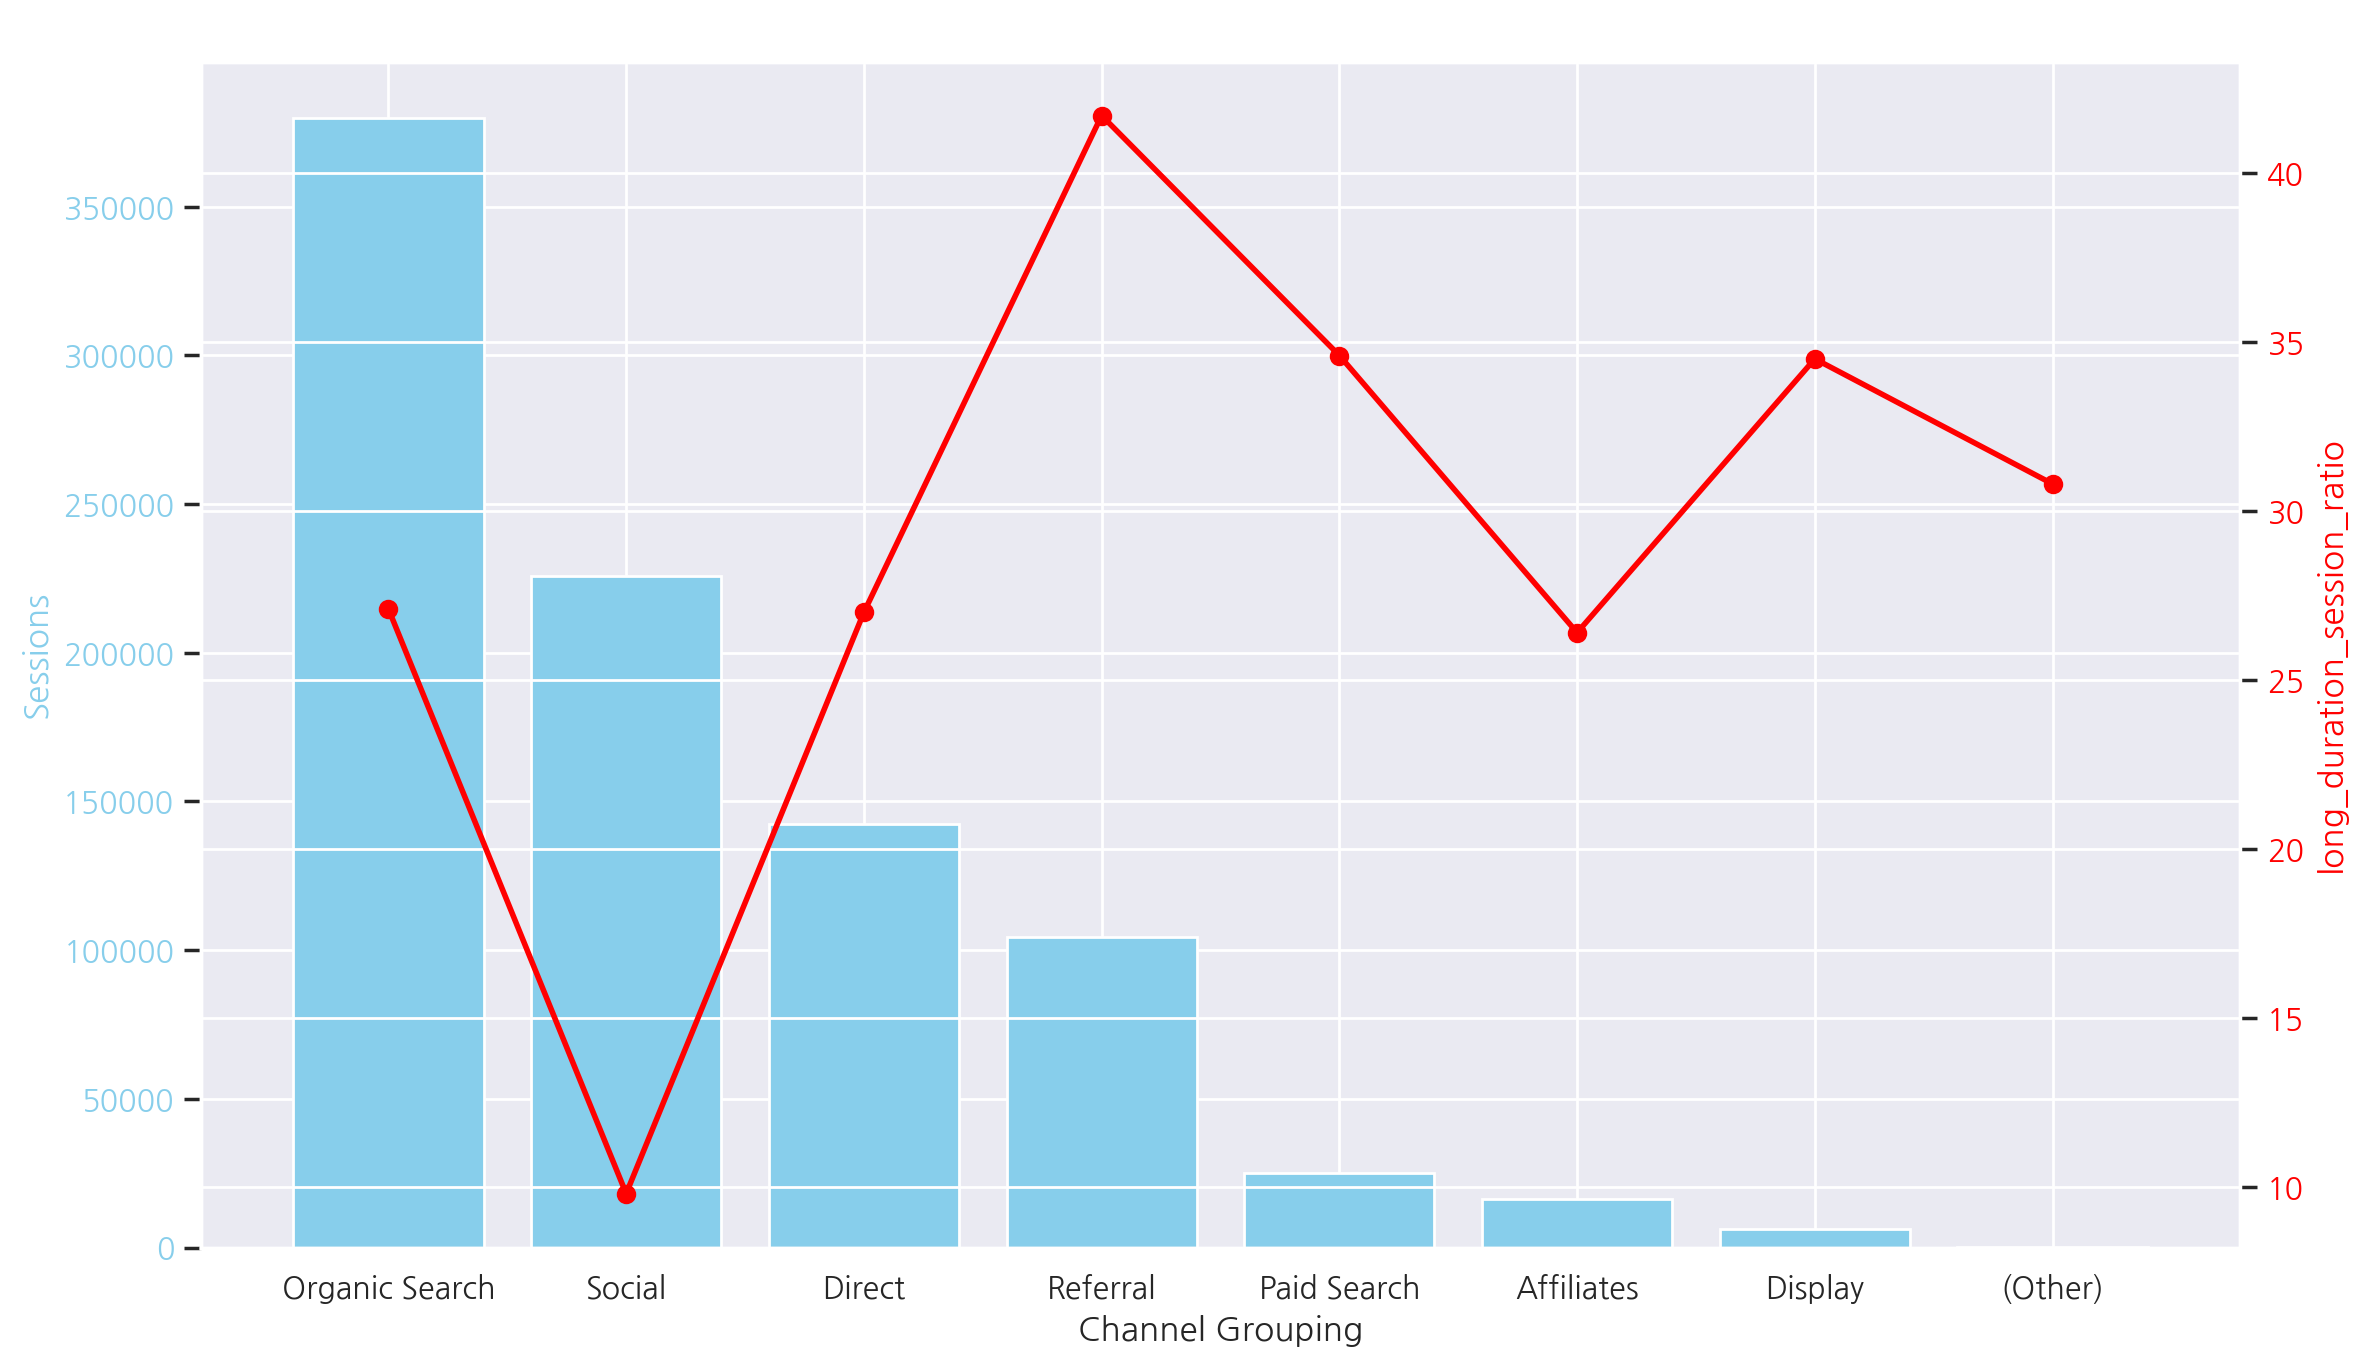

In [ ]:
# bar & line chart
fig, ax1 = plt.subplots(figsize=(12, 7))

# 세션 수 막대그래프 (왼쪽 y축)
color = 'skyblue'
ax1.set_xlabel('Channel Grouping')
ax1.set_ylabel('Sessions', color=color)
ax1.bar(long_time['channel'], long_time['total_sessions'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# 체류시간이 긴 비율 선그래프 (오른쪽 y축)
ax2 = ax1.twinx()
color = 'red'
ax2.set_ylabel('long_duration_session_ratio', color=color)
ax2.plot(long_time['channel'], long_time['long_stay_percent'], color=color, marker='o', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

# 제목 및 레이아웃
plt.title(' ')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 2-2. channelGrouping별 이탈률(bounces 기준)

- channelGrouping별  
totals.bounces을 이용해 종료세션 집계 및 세션 수를 기반으로 이탈률 계산
('totals.bounces = 1' 인 경우 이탈 세션)





In [ ]:
#channelGrouping별 이탈률(bounces 기준)
query="""
SELECT
  channelGrouping,
  COUNT(DISTINCT CONCAT(fullVisitorId, "-", CAST(visitId AS STRING))) AS sessions,
  SUM(totals.bounces) AS sum_exit,
  SAFE_DIVIDE(SUM(totals.bounces),
              COUNT(DISTINCT CONCAT(fullVisitorId, "-", CAST(visitId AS STRING)))) AS exit_rate
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE _TABLE_SUFFIX BETWEEN '20160801' AND '20170731'
GROUP BY channelGrouping
ORDER BY sessions DESC

"""
exit_rate= client.query(query).result().to_dataframe()
exit_rate

,channelGrouping,sessions,sum_exit,exit_rate
0,Organic Search,379792,183655,0.483567
1,Social,225807,147354,0.652566
2,Direct,142456,70685,0.496188
3,Referral,104265,27132,0.260222
4,Paid Search,25220,9605,0.380849
5,Affiliates,16320,8671,0.531311
6,Display,6220,2234,0.359164
7,(Other),120,56,0.466667


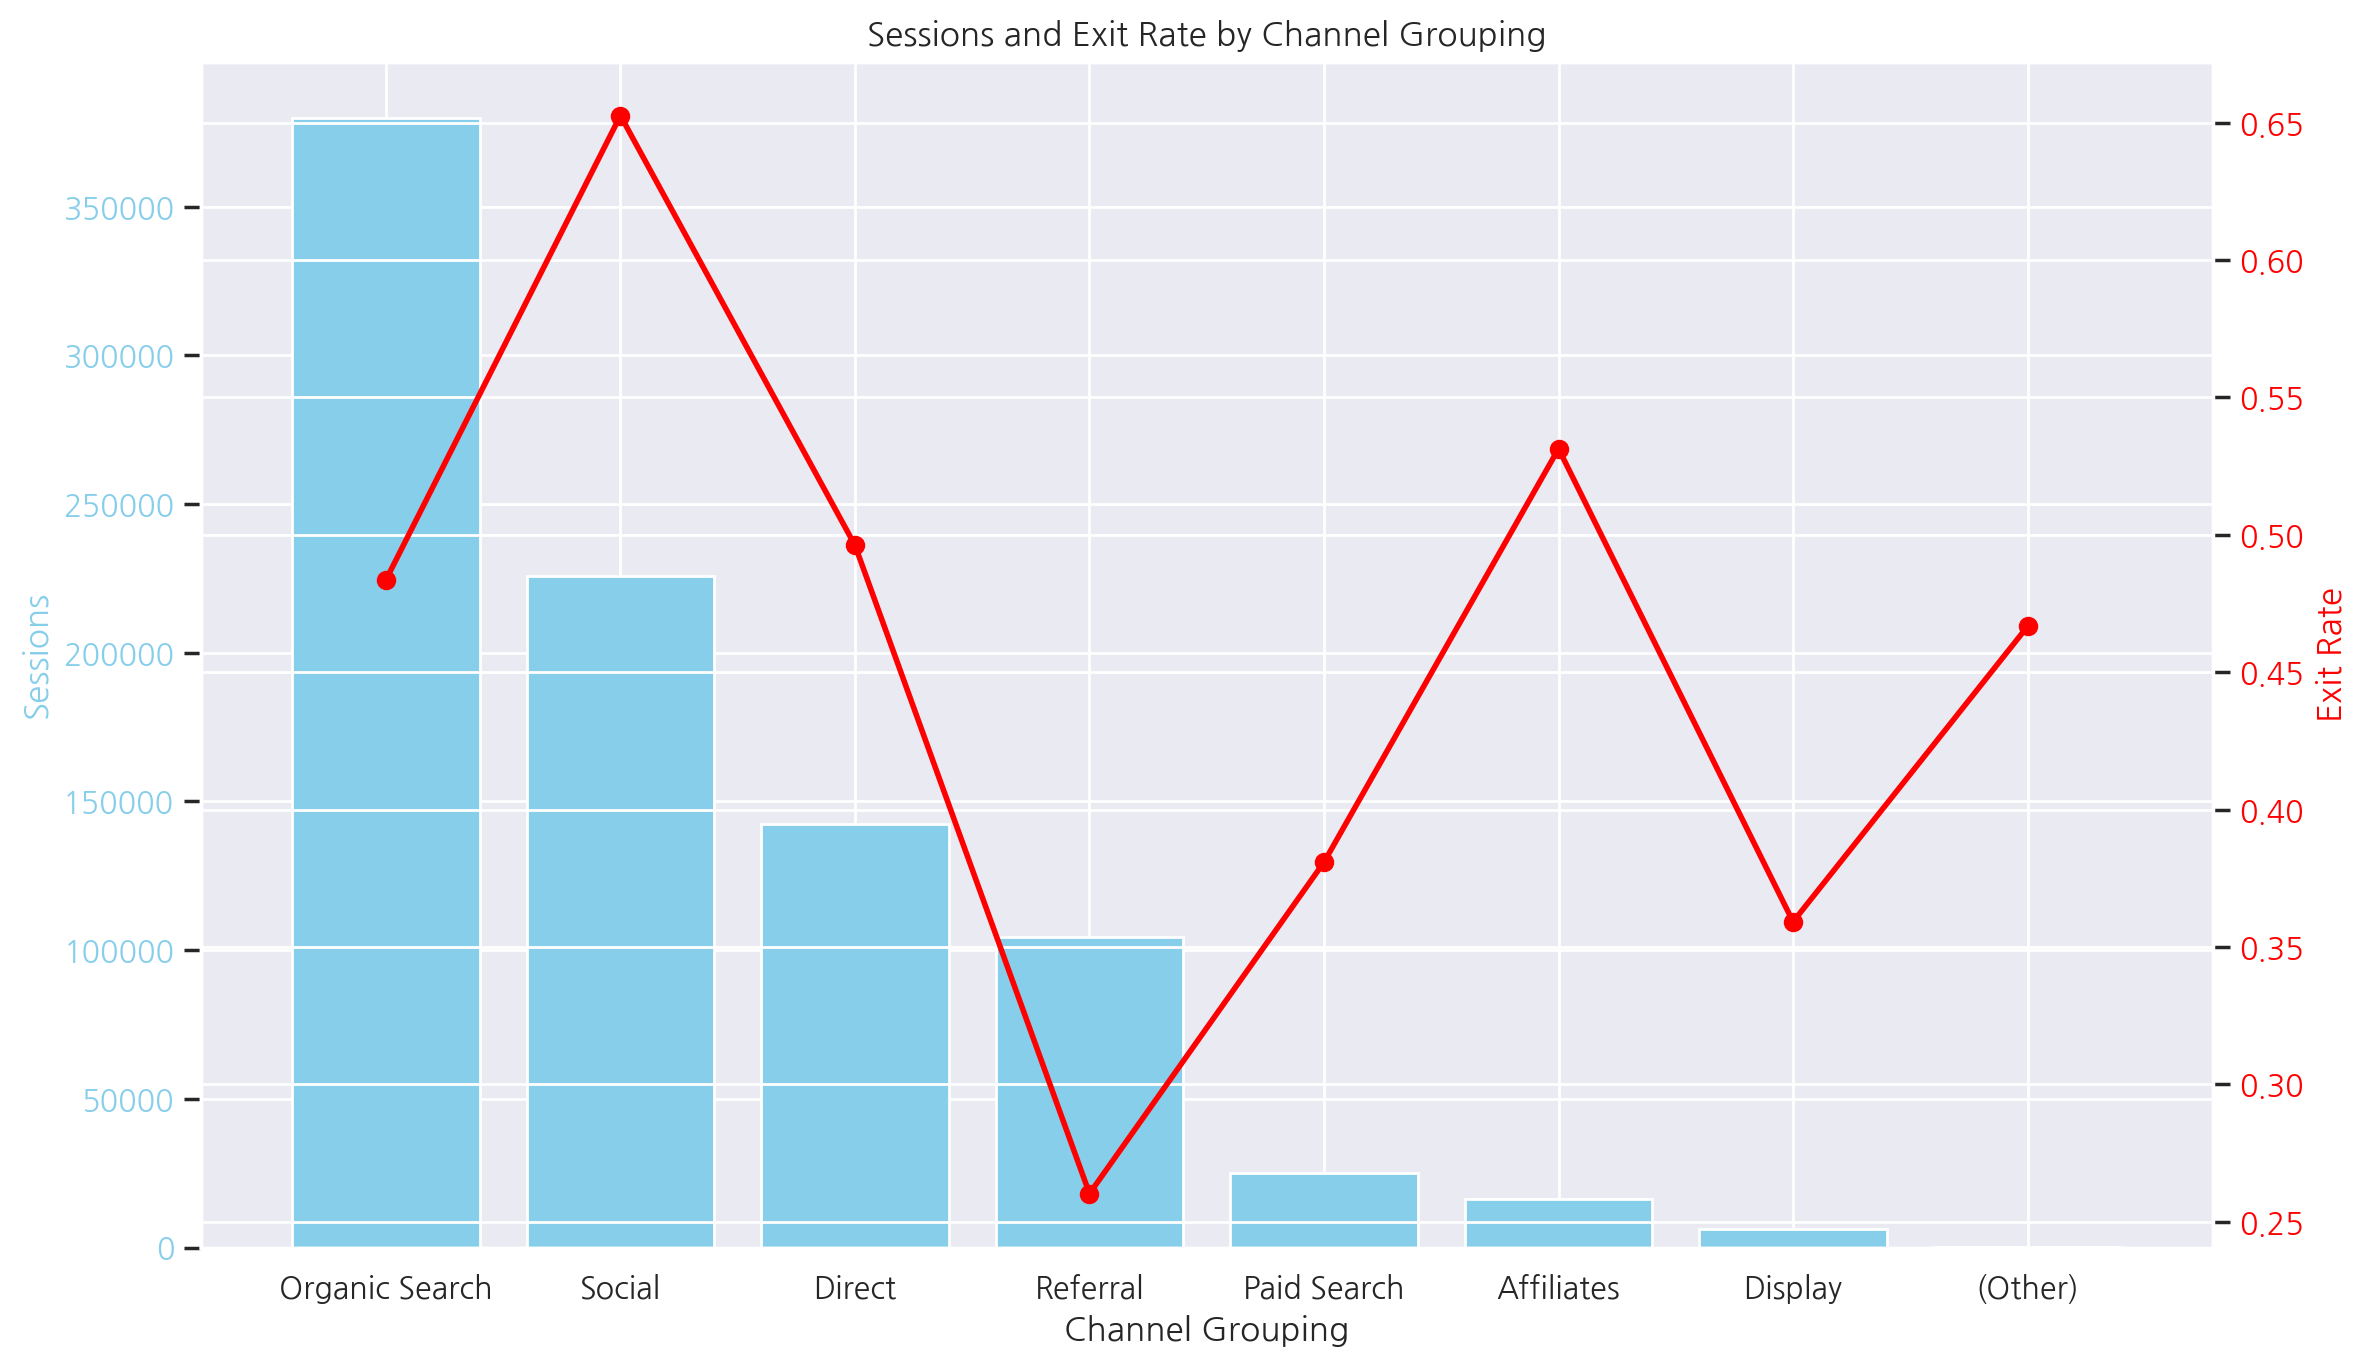

In [ ]:
# bar & line chart
fig, ax1 = plt.subplots(figsize=(12, 7))

# 세션 수 막대그래프 (왼쪽 y축)
color = 'skyblue'
ax1.set_xlabel('Channel Grouping')
ax1.set_ylabel('Sessions', color=color)
ax1.bar(exit_rate['channelGrouping'], exit_rate['sessions'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# 이탈률 선그래프 (오른쪽 y축)
ax2 = ax1.twinx()
color = 'red'
ax2.set_ylabel('Exit Rate', color=color)
ax2.plot(exit_rate['channelGrouping'], exit_rate['exit_rate'], color=color, marker='o', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

# 제목 및 레이아웃
plt.title('Sessions and Exit Rate by Channel Grouping')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 2-3. channelGrouping별 이탈률 (eventAction 기준)

- channelGrouping별 eventAction을 기준으로 사용자 여정 이탈률 비교
- sessions CTE
  - 모든 fullVisitorId와 visitId의 조합
- sessions_actions CTE
  - 각 조합별 액션 타입 배열
- session_labels CTE
  - 액션 타입이 2,3,5,6인 경우 activate, 4,7,8인 경우 other, 1이나 0인 경우 또는 그 외의 숫자는 bounce로 처리
- user_labels CTE
  - 조건으로 고객별 라벨 부여
- 최종 SELECT
  - fullVisitorId를 기준으로 중복 제거하고 카운트

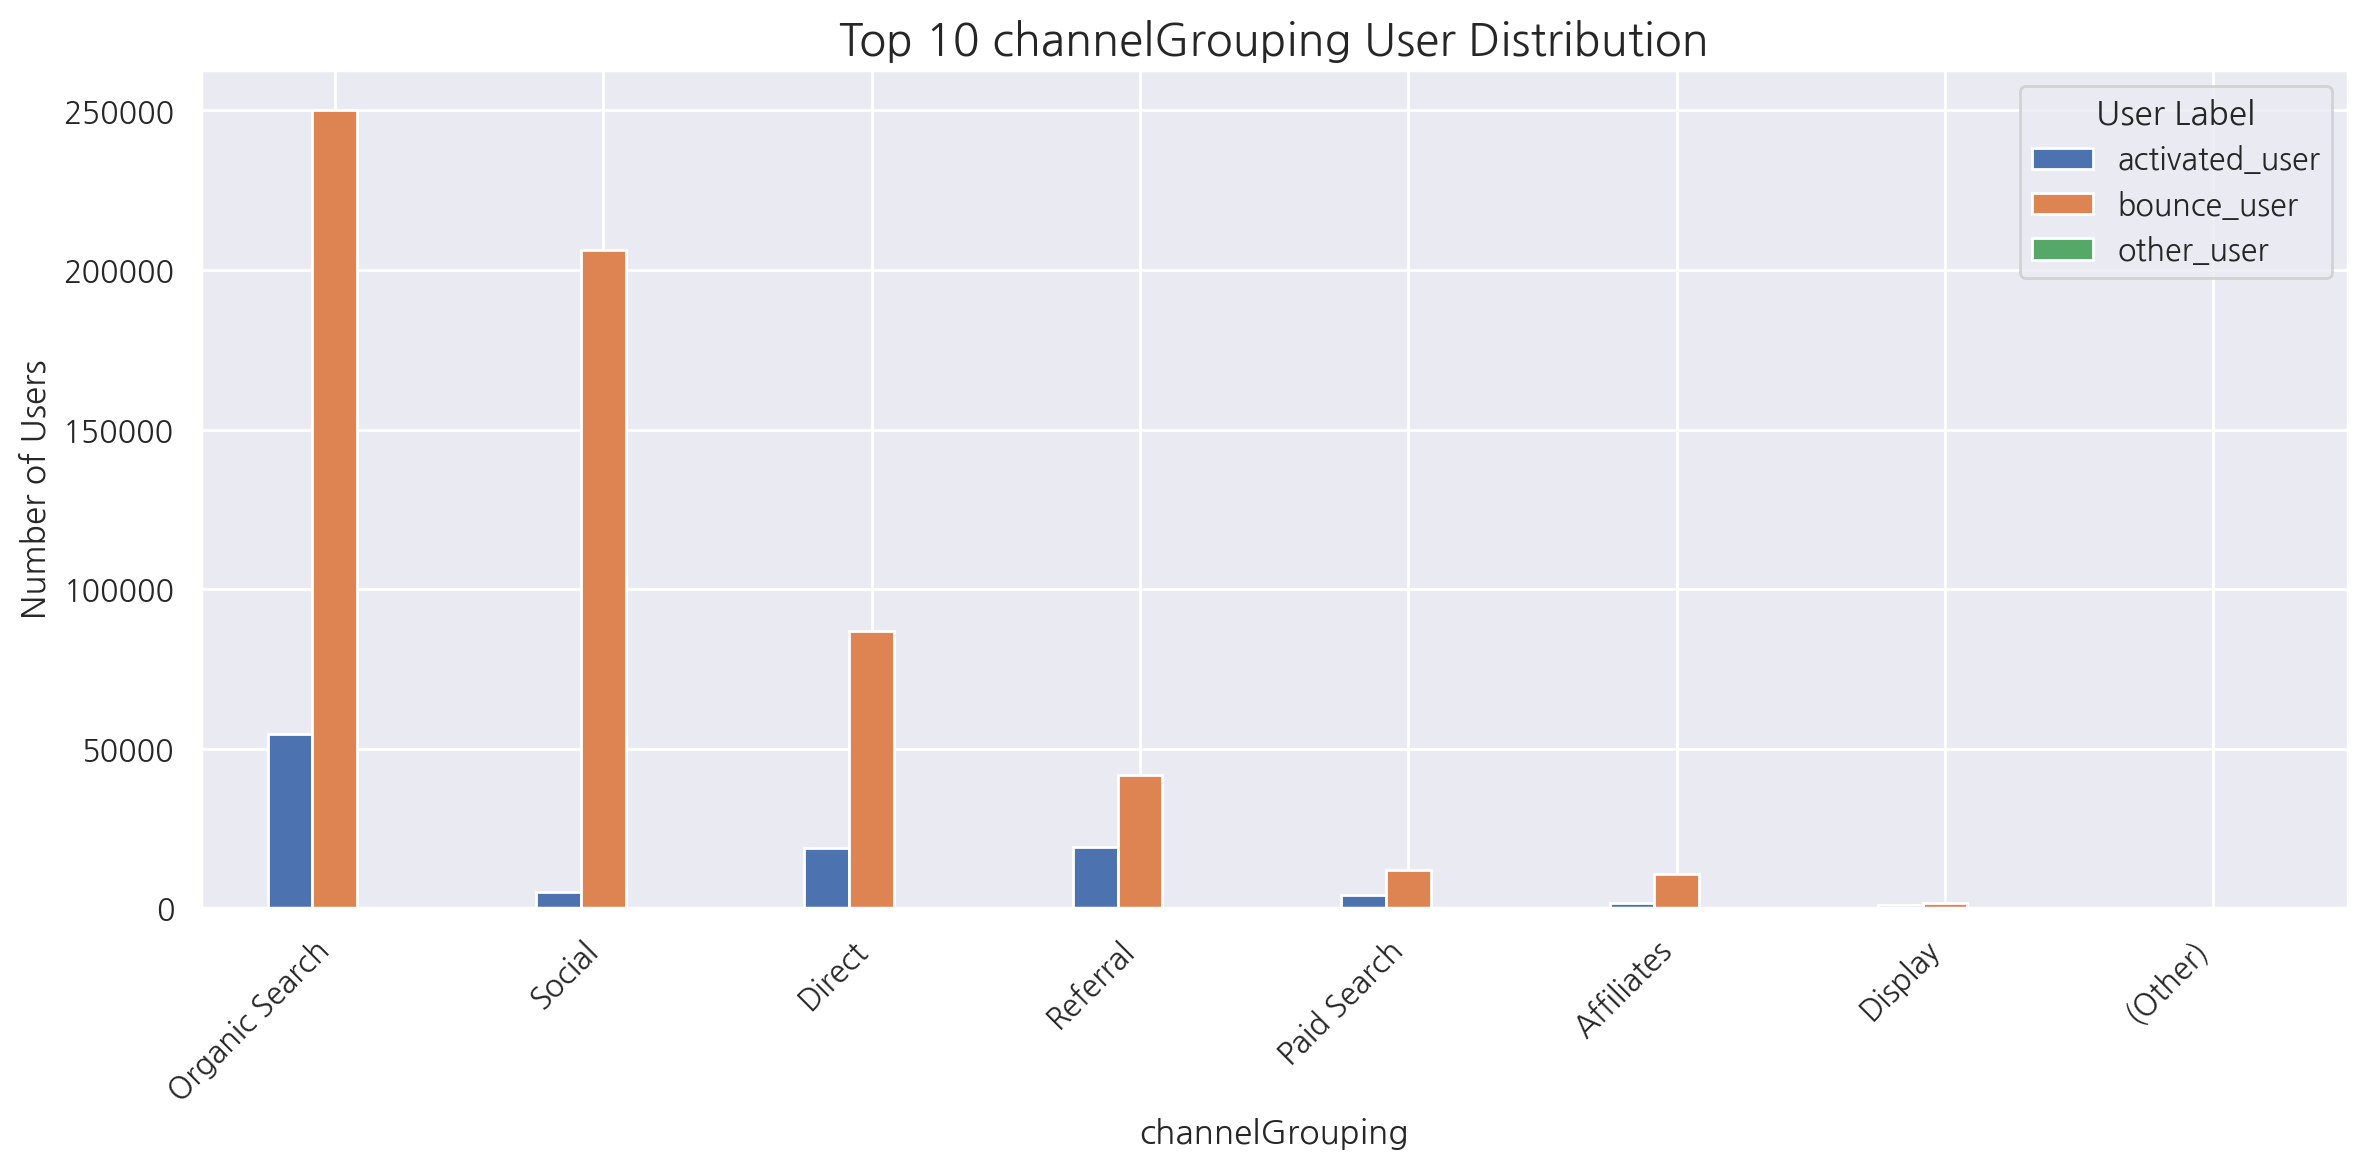

In [ ]:
query = f"""
WITH sessions AS (
  SELECT
    fullVisitorId,
    visitId,
    CONCAT(trafficSource.source, '_', trafficSource.medium) AS source_medium,
    channelGrouping
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
),

session_actions AS (
  SELECT
    fullVisitorId,
    visitId,
    ARRAY_AGG(DISTINCT hits.eCommerceAction.action_type IGNORE NULLS) AS action_types
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits
  WHERE
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
  GROUP BY fullVisitorId, visitId
),

session_labels AS (
  SELECT
    s.fullVisitorId,
    s.visitId,
    s.channelGrouping,
    CASE
      WHEN EXISTS (SELECT 1 FROM UNNEST(sa.action_types) AS x WHERE x IN ('2','3','5','6')) THEN 'activated'
      WHEN EXISTS (SELECT 1 FROM UNNEST(sa.action_types) AS x WHERE x IN ('4','7','8')) THEN 'other'
      ELSE 'bounce'
    END AS session_label
  FROM sessions s
  LEFT JOIN session_actions sa
    ON s.fullVisitorId = sa.fullVisitorId
   AND s.visitId = sa.visitId
),

user_labels AS (
  SELECT
    fullVisitorId,
    ANY_VALUE(channelGrouping) AS channelGrouping,
    CASE
      WHEN COUNTIF(session_label = 'activated') > 0 THEN 'activated_user'
      WHEN COUNTIF(session_label = 'bounce') > 0 THEN 'bounce_user'
      WHEN COUNTIF(session_label = 'other') > 0 THEN 'other_user'
      ELSE 'unknown_user'
    END AS user_label
  FROM session_labels
  GROUP BY fullVisitorId
)

SELECT
  user_label,
  channelGrouping,
  COUNT(DISTINCT fullVisitorId) AS users
FROM user_labels
GROUP BY user_label, channelGrouping
ORDER BY channelGrouping, user_label

"""
x= client.query(query).result().to_dataframe()
x

import matplotlib.pyplot as plt
import pandas as pd

# 쿼리 결과 DataFrame이 x라고 가정
# 상위 10 source_medium 추출 (유저 수 기준)
top_sources = x.groupby("channelGrouping")["users"].sum().sort_values(ascending=False).head(10).index

# 상위 10 source_medium만 필터링
x_top = x[x["channelGrouping"].isin(top_sources)]

# pivot table 생성 (user_label별)
pivot_df = x_top.pivot(index="channelGrouping", columns="user_label", values="users").fillna(0)

# stacked bar chart (내림차순 정렬)
pivot_df = pivot_df.loc[pivot_df.sum(axis=1).sort_values(ascending=False).index]

pivot_df.plot(kind="bar", stacked=False, figsize=(12,6))

plt.title("Top 10 channelGrouping User Distribution", fontsize=16)
plt.xlabel("channelGrouping", fontsize=12)
plt.ylabel("Number of Users", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.legend(title="User Label")
plt.tight_layout()
plt.show()


# 3. R(Retention)

## 3-1. channelgrouping별 7일/30일이내 재방문

- channelGrouping별  
 유저의 최초 방문일을 기준으로 7일 & 30일 이내 세션이 다시 발생했는지 확인하여 재방문율 계산
- first_sessions CTE
  - 최초 방문일 계산
- all_sessions CTE
  - 모든 세션의 방문일 추출
- day_activity CTE
  - 첫 방문일 다음날 ~ 7일/30일 후 까지 세션이 있는지 확인
- summary CTE
  - 유입채널별 재방문 유저 합산
- 최종 SELECT
  - 최초 유입 채널별 재방문율 계산

In [ ]:
## channelgrouping별 7일/30일이내 재방문율
query="""
WITH first_sessions AS (
  SELECT
    fullVisitorId,
    MIN(PARSE_DATE('%Y%m%d', date)) AS first_visit_date,-- 최초 방문일
    ANY_VALUE(channelGrouping) AS channelGrouping -- 첫방문 당시의 채널 그룹
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170731'
  GROUP BY
    fullVisitorId
),

all_sessions AS (
  SELECT
    fullVisitorId,
    PARSE_DATE('%Y%m%d', date) AS session_date
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170731'
),

day_activity AS (
  SELECT
    f.channelGrouping,
    f.first_visit_date,
    f.fullVisitorId,
    -- 첫방문 다음날부터 7일후 사이에 세션이 있으면 1, 없으면 0
    MAX(CASE WHEN s.session_date BETWEEN DATE_ADD(f.first_visit_date, INTERVAL 1 DAY)
                             AND DATE_ADD(f.first_visit_date, INTERVAL 7 DAY)
     THEN 1 ELSE 0 END) AS is_retained_day7,
    -- 첫방문 다음날부터 30일후 사이에 세션이 있으면 1, 없으면 0
    MAX(CASE WHEN s.session_date BETWEEN DATE_ADD(f.first_visit_date, INTERVAL 1 DAY)
                             AND DATE_ADD(f.first_visit_date, INTERVAL 30 DAY)
     THEN 1 ELSE 0 END) AS is_retained_day30

  FROM
    first_sessions f
  LEFT JOIN
    all_sessions s
  ON
    f.fullVisitorId = s.fullVisitorId
  GROUP BY
    f.channelGrouping, f.first_visit_date, f.fullVisitorId
),

summary AS (
  SELECT
    channelGrouping,
    COUNT(*) AS cohort_size,
    SUM(is_retained_day7) AS retained_users_day7,
    SUM(is_retained_day30) AS retained_users_day30
  FROM
    day_activity
  GROUP BY
    channelGrouping
)

SELECT
  channelGrouping AS channel_group,
  cohort_size AS users,
  CAST(retained_users_day7 AS FLOAT64) / cohort_size AS day7_retention_rate,
  CAST(retained_users_day30 AS FLOAT64) / cohort_size AS day30_retention_rate
FROM
  summary
ORDER BY
  users DESC;

    """
retention_channelGrouping= client.query(query).result().to_dataframe()
retention_channelGrouping


,channel_group,users,day7_retention_rate,day30_retention_rate
0,Organic Search,303609,0.054228,0.078578
1,Social,210897,0.015894,0.028156
2,Direct,105633,0.077353,0.102345
3,Referral,60631,0.121143,0.200656
4,Paid Search,16207,0.097736,0.142222
5,Affiliates,12503,0.069343,0.089658
6,Display,2732,0.196193,0.367862
7,(Other),60,0.266667,0.566667


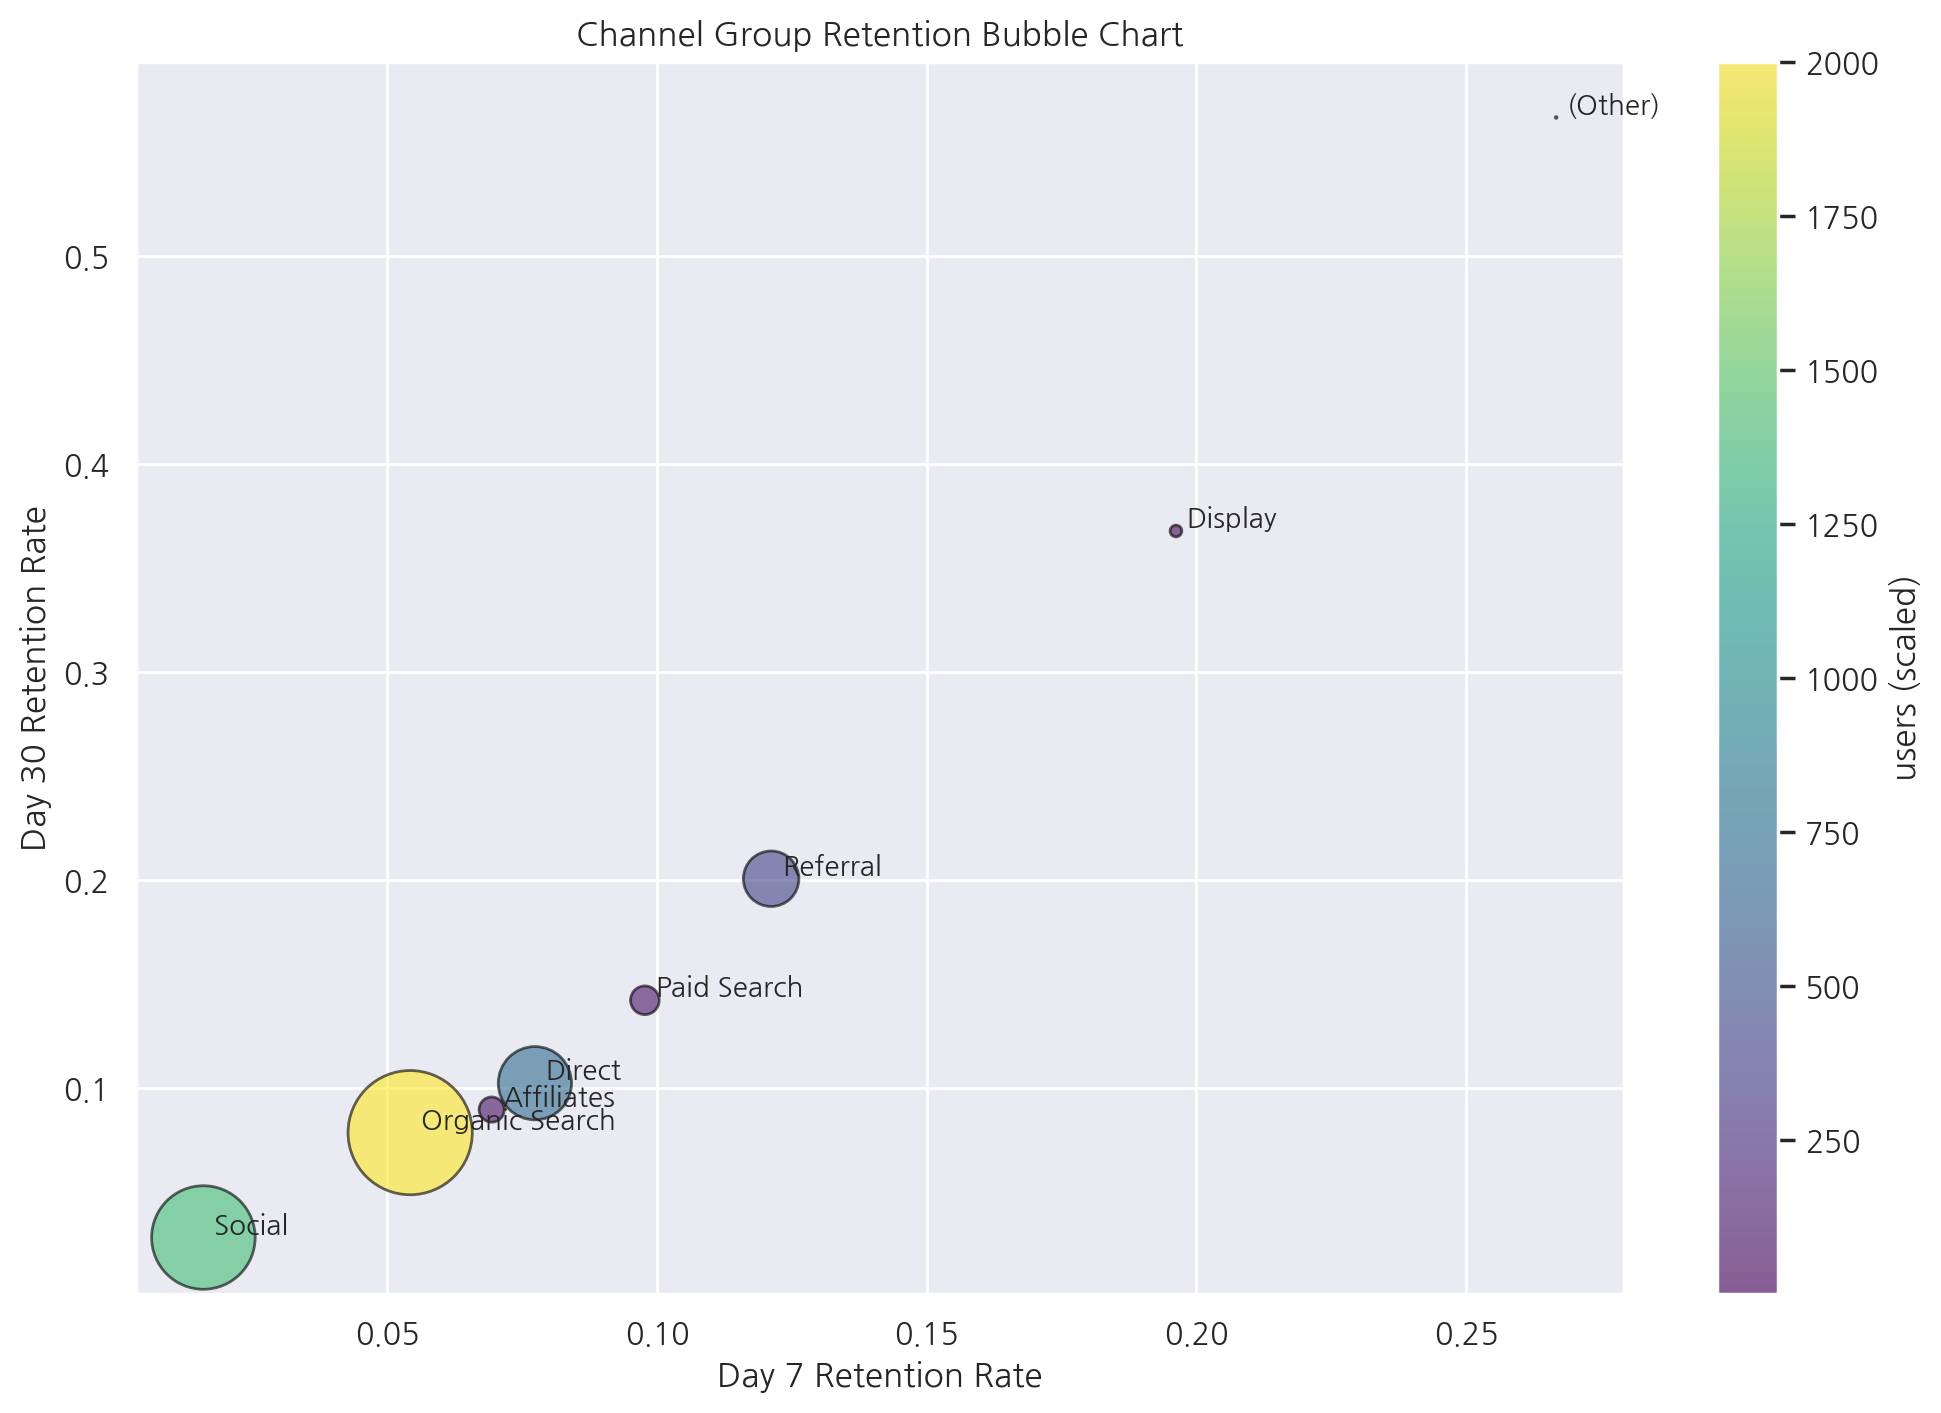

In [ ]:
#버블차트 시각화

# 버블 크기 비율 조정
size_scale = 2000  # 원하는 크기 비율로 조정
bubble_size = retention_channelGrouping['users'] / retention_channelGrouping['users'].max() * size_scale

# 버블차트 그리기
plt.figure(figsize=(12,8))
scatter = plt.scatter(
    x=retention_channelGrouping['day7_retention_rate'],
    y=retention_channelGrouping['day30_retention_rate'],
    s=bubble_size,
    alpha=0.6,
    c=bubble_size,  # 색상도 세션수에 비례
    cmap='viridis',
    edgecolors='black'
)

# 레이블 표시
for i, txt in enumerate(retention_channelGrouping['channel_group']):
    plt.text(
        retention_channelGrouping['day7_retention_rate'][i]+0.002,
        retention_channelGrouping['day30_retention_rate'][i]+0.002,
        txt,
        fontsize=10
    )

plt.xlabel('Day 7 Retention Rate')
plt.ylabel('Day 30 Retention Rate')
plt.title('Channel Group Retention Bubble Chart')
plt.colorbar(scatter, label='users (scaled)')
plt.grid(True)
plt.show()


# 4. R(Revenue)

## 4-1. channelgrouping별 ARPU (1인당 평균 수익)


- channelGrouping별  
totals.totalTransactionRevenue을 활용한 총 수익 & 1인당 평균 수익 집계

In [ ]:
# channelGrouping ARPU (1인당 평균 수익)
query = f"""
SELECT
  channelGrouping,
  COUNT(DISTINCT fullVisitorId) AS users,
  SUM(totals.totalTransactionRevenue)/1e6 AS total_revenue,
  SAFE_DIVIDE(SUM(totals.totalTransactionRevenue)/1e6, COUNT(DISTINCT fullVisitorId)) AS ARPU
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
  _TABLE_SUFFIX BETWEEN '20160801' AND '20170731'
GROUP BY
  channelGrouping
ORDER BY
  users DESC;
"""
result = client.query(query).result().to_dataframe()
display(result.head(50))

,channelGrouping,users,total_revenue,ARPU
0,Organic Search,310493,376347.27,1.212096
1,Social,212176,8396.78,0.039575
2,Direct,109527,495981.12,4.528391
3,Referral,65423,712111.47,10.884727
4,Paid Search,18651,47459.95,2.544633
5,Affiliates,13356,654.38,0.048995
6,Display,4082,130296.27,31.919713
7,(Other),90,11.99,0.133222


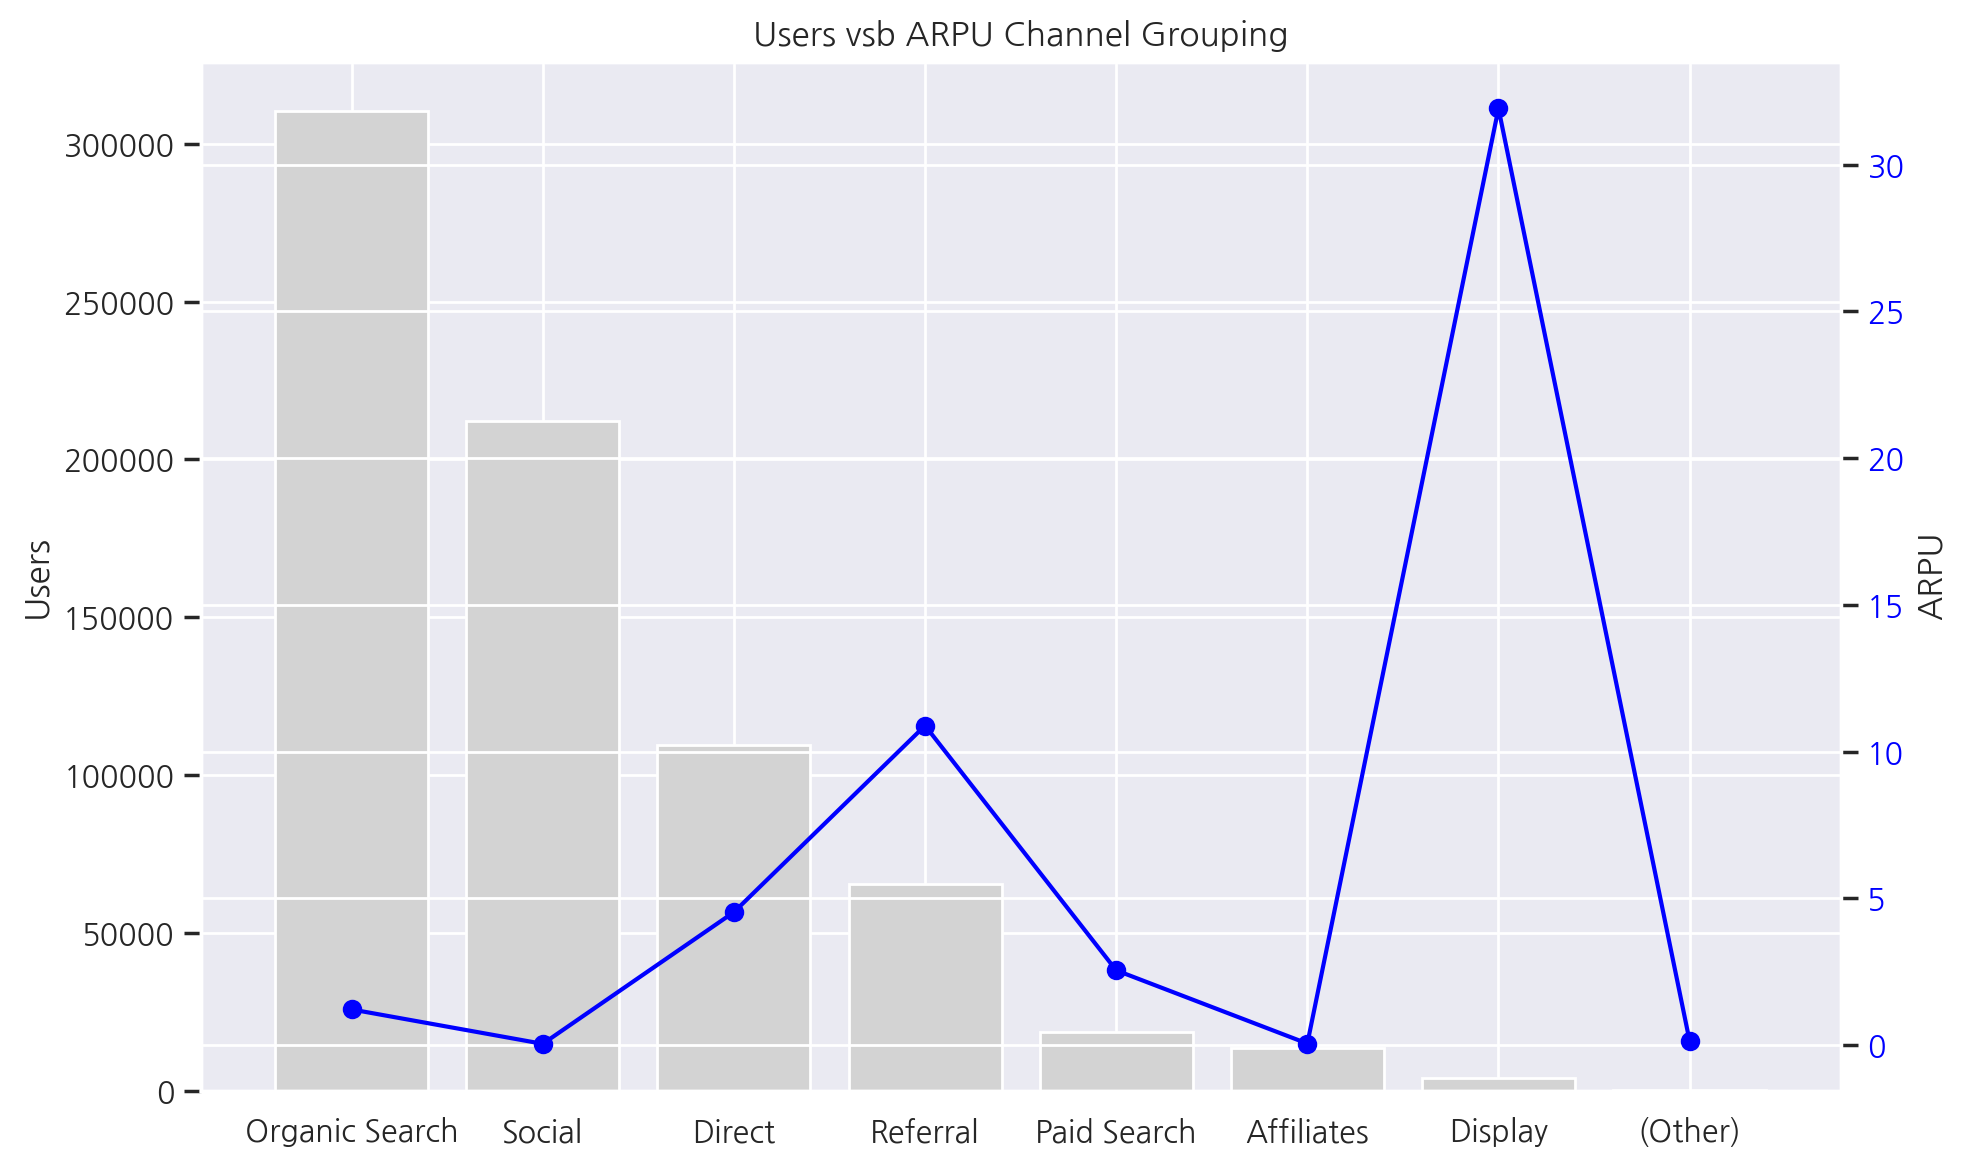

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,6))

# 첫 번째 Y축 (users)
ax1.bar(result["channelGrouping"], result["users"], color="lightgray", label="Users")
ax1.set_ylabel("Users")
ax1.tick_params(axis="y")

# 두 번째 Y축 (total_revenue)
ax2 = ax1.twinx()
ax2.plot(result["channelGrouping"], result["ARPU"], color="blue", marker="o", label="ARPU")
ax2.set_ylabel("ARPU")
ax2.tick_params(axis="y", labelcolor="blue")

# 제목
plt.title("Users vsb ARPU Channel Grouping")
plt.xticks(rotation=45)
fig.tight_layout()
plt.show()


## 4-2. channelgrouingp별 구매 전환율


- 세션 중 실제 거래가 발생한 경우에만 값이 있는 totals.transactions을 통해 구매한 사용자 파악  
(구매자 수 / 전체 사용자 수)로 구매 전환율 계산

In [ ]:
# channelgroup별 구매 전환율
query = f"""
SELECT
  channelGrouping,
  COUNT(DISTINCT fullVisitorId) AS users, -- 해당 채널을 통해 유입된 고유 사용자 수
  COUNT(DISTINCT CASE WHEN totals.transactions IS NOT NULL THEN fullVisitorId END) AS purchasers,
  SAFE_DIVIDE(COUNT(DISTINCT CASE WHEN totals.transactions IS NOT NULL THEN fullVisitorId END),
              COUNT(DISTINCT fullVisitorId)) AS conversion_rate
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
  _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
GROUP BY
  channelGrouping
ORDER BY
  users DESC;
"""
result = client.query(query).result().to_dataframe()
display(result.head(50))

,channelGrouping,users,purchasers,conversion_rate
0,Organic Search,311607,3155,0.010125
1,Social,212374,100,0.000471
2,Direct,109830,1725,0.015706
3,Referral,65661,4593,0.069950
4,Paid Search,18702,444,0.023741
5,Affiliates,13400,9,0.000672
6,Display,4103,122,0.029734
7,(Other),90,1,0.011111


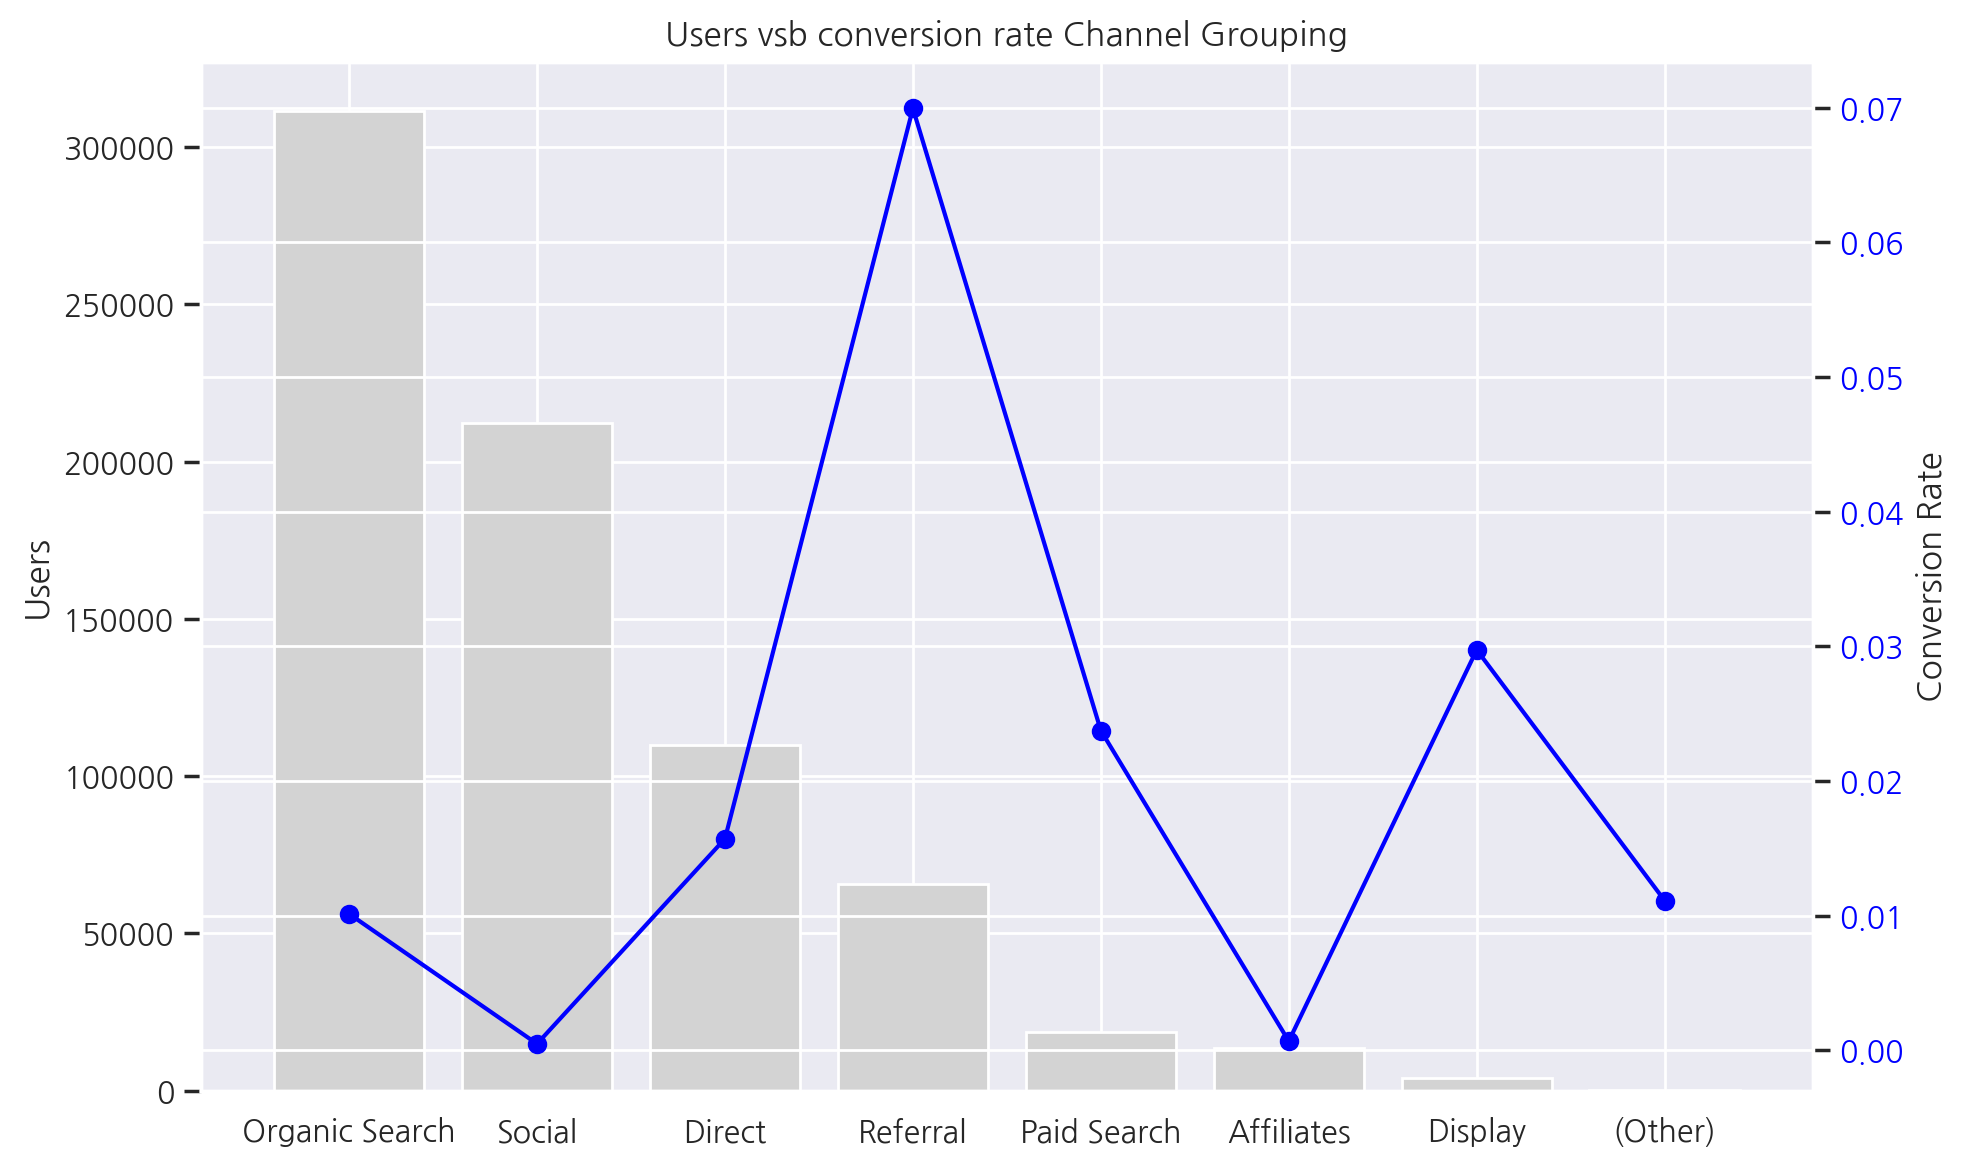

In [ ]:
# Bar Chart
fig, ax1 = plt.subplots(figsize=(10,6))

# 첫 번째 Y축 (users)
ax1.bar(result["channelGrouping"], result["users"], color="lightgray", label="Users")
ax1.set_ylabel("Users")
ax1.tick_params(axis="y")

# 두 번째 Y축 (total_revenue)
ax2 = ax1.twinx()
ax2.plot(result["channelGrouping"], result["conversion_rate"], color="blue", marker="o", label="Conversion Rate")
ax2.set_ylabel("Conversion Rate")
ax2.tick_params(axis="y", labelcolor="blue")

# 제목
plt.title("Users vsb conversion rate Channel Grouping")
plt.xticks(rotation=45)
fig.tight_layout()
plt.show()


## 4-3. channelgroup별 첫 방문 이후 평균 구매 소요일

- channelGrouping별 첫 방문 세션의 날짜와 구매 세션의 날짜 차의 평균으로 평균 구매 소요일 집계
- channelGrouping CTE
  - 방문자 식별자, 세션 날짜, 유입경로, 거래여부의 필요한 컬럼 추출
- first_sessions CTE
  - 각 방문자의 첫 방문 세션 날짜 추출
- first_purchases CTE
  - 방문자별 최초 구매일 계산 (거래가 발생한 세션 중 가장 빠른 날짜 선택)
- 최종 SELECT
  - 최초 방문일과 최초 구매일을 방문자 기준으로 조인

In [ ]:
query = f"""
WITH channelGrouping AS (
  SELECT
    fullVisitorId,
    PARSE_DATE('%Y%m%d', date) AS session_date,
    channelGrouping,
    totals.transactions AS transactions
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
),
first_sessions AS (
  SELECT
    fullVisitorId,
    MIN(session_date) AS first_visit_date
  FROM
    channelGrouping
  GROUP BY
    fullVisitorId
),
first_purchases AS (
  SELECT
    fullVisitorId,
    MIN(session_date) AS first_purchase_date
  FROM
    channelGrouping
  WHERE
    transactions IS NOT NULL
  GROUP BY
    fullVisitorId
)
SELECT
  c.channelGrouping,
  AVG(DATE_DIFF(fp.first_purchase_date, fs.first_visit_date, DAY)) AS avg_days_to_purchase
FROM
  first_sessions fs
JOIN
  first_purchases fp
ON
  fs.fullVisitorId = fp.fullVisitorId
JOIN
  channelGrouping c
ON
  c.fullVisitorId = fs.fullVisitorId AND c.session_date = fs.first_visit_date
GROUP BY
  c.channelGrouping
ORDER BY
  avg_days_to_purchase desc;
"""
result = client.query(query).result().to_dataframe()
display(result.head(50))

,channelGrouping,avg_days_to_purchase
0,Referral,10.372754
1,Direct,9.039033
2,Display,7.918605
3,Social,7.230769
4,Paid Search,6.462347
5,Organic Search,6.457444
6,Affiliates,2.785714
7,(Other),0.000000


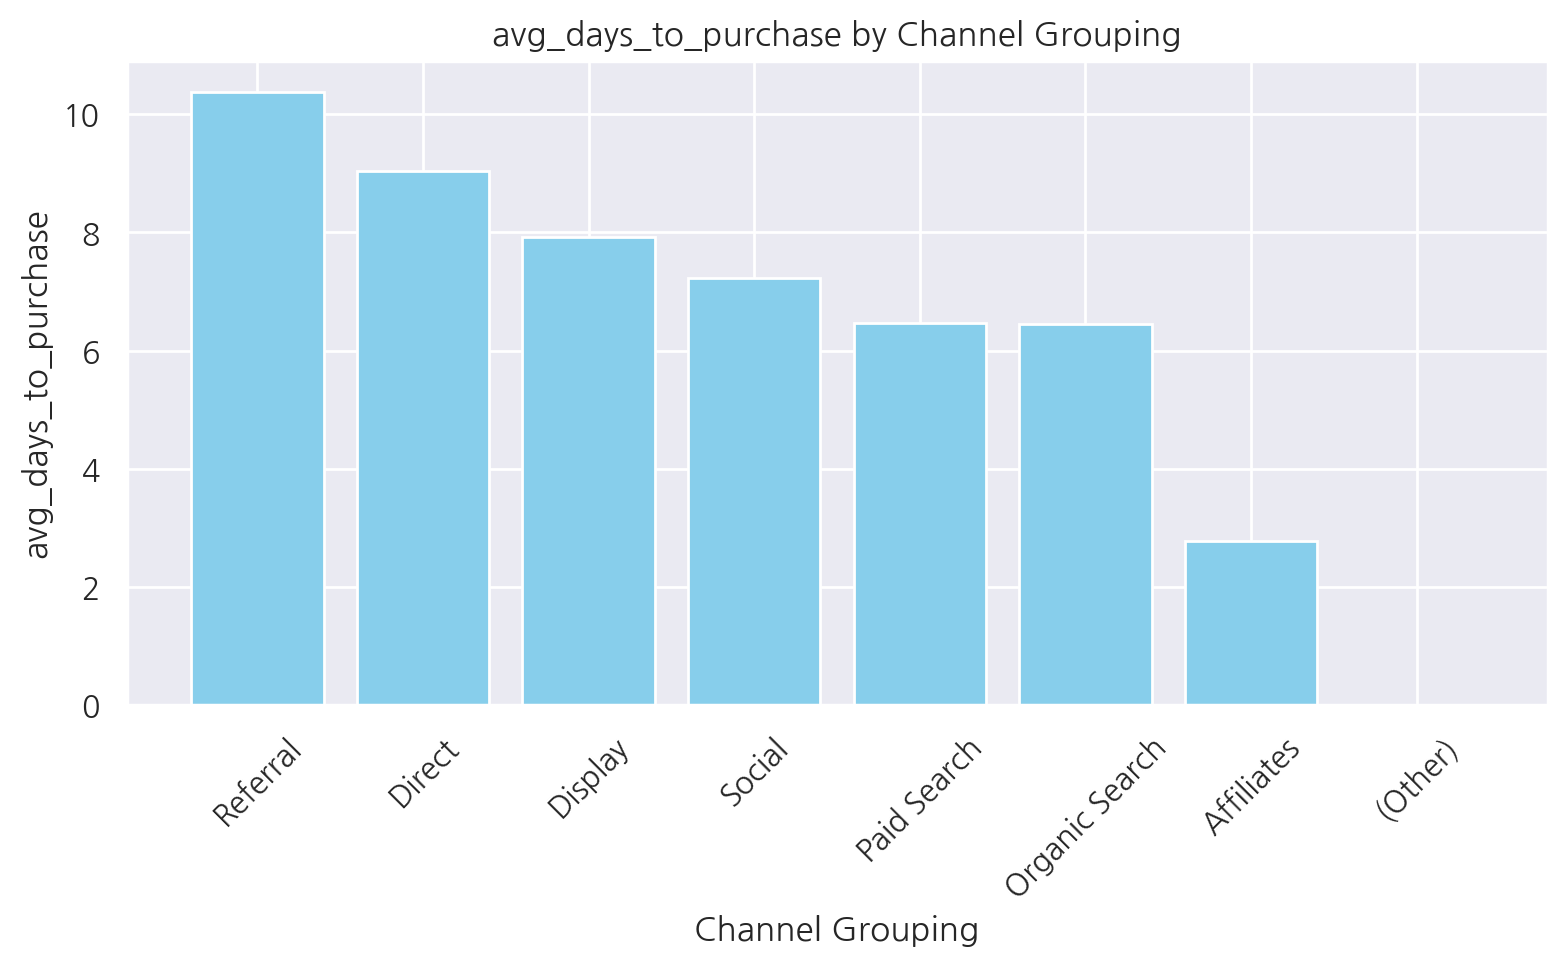

In [ ]:
# bar chart
plt.figure(figsize=(8,5))
plt.bar(result['channelGrouping'], result['avg_days_to_purchase'], color='skyblue')

plt.xlabel('Channel Grouping')
plt.ylabel('avg_days_to_purchase')
plt.title('avg_days_to_purchase by Channel Grouping')
plt.xticks(rotation=45)  # x축 라벨 45도 회전 (가독성 개선)
plt.tight_layout()
plt.show()
